# **Model Selection & Evaluation**

* Establish baselines; connect metrics to business trade-offs.

# Objectives

- Build, evaluate, and compare baseline models for credit card fraud detection using the processed dataset prepared in 01_ETL.ipynb. 
- Establish reliable performance benchmarks and identify the optimal strategy for handling class imbalance.
- Link model metrics (precision, recall, PR AUC) to practical business trade-offs such as fraud detection rate versus investigation workload.

**Inputs**
- Processed dataset: data/processed/card_transdata_processed.csv (100,000 stratified sample rows).
- The sample preserves the original fraud ratio of 8.74% from the full Kaggle dataset (1M rows) to maintain representativeness while ensuring efficient training.

**What this notebook does:**
- Load the processed dataset and prepare training, validation, and test splits (60/20/20).
- Establish and compare three imbalance-handling strategies:
    - No weighting (baseline)
    - Class weighting (class_weight='balanced')
    - SMOTE oversampling (applied to training set only).
    - Train and evaluate two baseline models:
        - Logistic Regression: Linear, interpretable benchmark
        - Decision Tree: Non-linear model capturing complex relationships
    - Assess validation and test performance using PR AUC (primary metric) and ROC AUC (secondary).
    - Conduct fine-grained threshold and confusion matrix analysis to connect model metrics with operational impact.
    - Export model metrics and threshold tables for Power BI dashboard visualisation.

**Outputs:**
- Performance comparison reports for all models and imbalance strategies (reports/).
- Saved threshold tables for visual analysis in Power BI dashboard.
- Insights and recommendations on threshold selection, business trade-offs, and model suitability for deployment.

**Note:**
This modelling uses a stratified 100k sample of the Kaggle synthetic credit card transactions dataset to ensure efficient runtime while maintaining the original fraud class balance. Full dataset details are documented in 01_ETL.ipynb.



---

# Change working directory

I need to change the working directory from the current folder to its parent folder (required because the notebook is being run from inside the jupyter notebooks subfolder). In the code below, I change the working directory from its current folder to its parent folder.  
* I access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Current_DA\\Credit_Card-Fraud_Analysis_Updated\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Current_DA\\Credit_Card-Fraud_Analysis_Updated'

# Section 1: Quick Load and Check of Dataframe

Quick steps to:
- Load processed file
- Check Dataframe Shape is as expected (100000, 17)
- Display first 5 rows to check loads as expected.


In [4]:
# =============================================================================
# Import all libraries needed for the notebook
# =============================================================================

# Core data manipulation and path handling
import pandas as pd  # Data manipulation and analysis
import numpy as np    # Numerical operations and array handling
from pathlib import Path  # Cross-platform file path handling

# Data visualisation
import matplotlib.pyplot as plt  # Static plotting
import seaborn as sns # Enhanced visual styling

# Display tools
from IPython.display import display  # Pretty display of DataFrames in Jupyter

# =============================================================================
# Machine Learning: Model preparation and evaluation
# =============================================================================
from sklearn.model_selection import train_test_split, GridSearchCV  # Data splitting and tuning
from sklearn.metrics import ConfusionMatrixDisplay  # Visualise confusion matrices
from sklearn.linear_model import LogisticRegression  # Linear baseline classifier
from sklearn.tree import DecisionTreeClassifier  # Simple tree model for interpretability
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Ensemble models
from xgboost import XGBClassifier  # Gradient boosting with high performance
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import matplotlib.pyplot as plt



# =============================================================================
# Model evaluation metrics
# =============================================================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,  # Core classification metrics
    precision_recall_curve, average_precision_score,  # PR curve metrics (preferred for imbalance)
    roc_auc_score, roc_curve, confusion_matrix,  # ROC and confusion matrix
    classification_report  # Summary table
)

# =============================================================================
# Load processed dataset (created from 100k stratified sample in 01 ETL.ipynb)
# Display the shape of the dataframe

df = pd.read_csv("data/processed/card_transdata_processed.csv") # Load processed data

df.shape # (rows, columns)


(100000, 17)

In [5]:
df.head() # Display first few rows of the dataframe

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,log_distance_from_home,log_distance_from_last_transaction,log_ratio_to_median_purchase_price,log_distance_from_home_bin,log_purchase_price_bin,log_distance_from_last_transaction_bin,online_high_distance,online_chip_category,online_and_chip
0,19.179396,0.178758,2.979353,1,0,0,1,0,3.004662,0.164461,1.381119,3,4,0,1,online_no_chip,0
1,47.192898,1.224832,0.293538,1,1,0,1,0,3.875212,0.799681,0.257381,4,0,2,1,online_with_chip,1
2,54.389043,5.290910,4.492304,1,1,0,0,0,4.014382,1.839106,1.703348,4,4,4,0,offline_with_chip,0
3,3.129745,0.607212,0.357527,1,0,0,1,0,1.418216,0.474501,0.305665,1,0,1,0,online_no_chip,0
4,0.925275,2.238057,0.684942,0,0,0,0,0,0.655069,1.174974,0.521731,0,1,3,0,offline_no_chip,0


# Section 1.1: Data Validation and Preparation

## Class Balance Verification

**Purpose:** Verify that the dataset maintains the expected fraud rate (8.74%) from the stratified sampling performed in the ETL pipeline.

**Expected Outcome:**
- Fraud rate: 8.74% 
- Non-fraud rate: 91.26%
- Imbalance ratio: approximately 1:10.4 (non-fraud to fraud)

## Feature and Target Split

**Purpose:** Prepare the dataset for modelling by separating features (X) and target variable (y).

**Dataset Composition:**
The dataset contains 17 columns total, split into features and target:

**Excluded Features from Modelling:**

1. **Fraud** - Target variable (what we're predicting)
2. **online_chip_category** - String categorical variable
   - Contains labels: "online_no_chip", "online_chip", "offline_no_chip", "offline_chip"
   - Redundant: underlying binary features (online_order and used_chip) already included
   - Created for hypothesis testing visualisation (H8) only
3. **Binned Variables** - Created for EDA visualisation only:
   - log_distance_from_home_bin - Categorical distance ranges
   - log_purchase_price_bin - Categorical price ratio ranges  
   - log_distance_from_last_transaction_bin - Categorical transaction distance ranges
   - Rationale: These binned features were created for visual exploration, rather modelling ( binning reduces numeric precision and discards detailed variation).

**Features Retained for Modelling:**

- Original features retained include:
    - distance_from_home - Geographic distance from customer's home address (km)
    - distance_from_last_transaction - Distance from previous transaction location (km)
    - ratio_to_median_purchase_price - Current purchase relative to customer's median spending
    - repeat_retailer - Whether customer previously transacted with retailer (binary: 0/1)
    - used_chip - Chip card authentication used (binary: 0/1)
    - used_pin_number - PIN verification used (binary: 0/1)
    - online_order - Transaction channel: online vs in-store (binary: 0/1)
- Log-Transformed features retained include:
    - log_distance_from_home- Reduces right skew in distance distribution
    - log_distance_from_last_transaction - Handles extreme distance outliers
    - log_ratio_to_median_purchase_price - Normalises purchase ratio distribution
    - Rationale: Both the original and log-transformed versions retained:
        - Tree-based models can split usage/importance as to version provides the strongest predictive power through their built-in feature selection.
        - Linear regression may prefer scaled log form for stability
- Engineered interaction features retained:
    - online_high_distance - Binary flag: online transaction far from home (combines channel + distance risk)
    - online_and_chip - Binary flag: online transaction using chip authentication

**Output:**
- **X**: Feature matrix (n_samples × 12 features) - all numeric predictors
- **y**: Binary target vector (n_samples) - fraud indicator (0 = legitimate, 1 = fraud)

**Feature Selection for Modelling Aim:**
- Balance information depth with model efficiency:  
    - Retain both raw and transformed features for flexibility  
    - Exclude redundant encoded categories  
    - Remove low-information binned variables  
    - Retain features that provide sufficient signal for modelling

In [6]:
# =============================================================================
# Section 1.1: Data Validation And Preparation
# =============================================================================
# Validates class balance and prepares features for modelling
# Ensures dataset integrity before model training begins
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Class Balance Verification
# ─────────────────────────────────────────────────────────────────────────────
# Confirm fraud rate matches expected 8.74% from stratified sampling in ETL
# Any mismatch indicates potential data loading or processing errors

# Calculate fraud statistics
fraud_count = int(df['fraud'].sum())        # Total number of fraudulent transactions
fraud_rate = df['fraud'].mean()             # Proportion of fraud (0 to 1)
total_rows = df.shape[0]                    # Total number of transactions

# Display fraud distribution clearly
print(f"Fraud rate: {fraud_rate:.2%} ({fraud_count:,} fraud cases out of {total_rows:,} total transactions)")

# ─────────────────────────────────────────────────────────────────────────────
# Verify against expected rate from ETL pipeline
# ─────────────────────────────────────────────────────────────────────────────
# Expected rate comes from sample_log.json created during stratified sampling
expected_fraud_rate = 0.0874  # 8.74% fraud rate from ETL stratified sampling
rate_difference = abs(fraud_rate - expected_fraud_rate)  # Absolute difference

# Check if observed rate matches expected (allow tiny floating point errors)
if rate_difference < 0.0001:
    print(f"✓ Class balance verified: matches expected rate ({expected_fraud_rate:.2%})")
else:
    print(f"Issue: Fraud rate {fraud_rate:.4%} differs from expected {expected_fraud_rate:.2%}")
    print(f"  Difference: {rate_difference:.4%}")

# Calculate and display imbalance ratio
imbalance_ratio = (1 - fraud_rate) / fraud_rate  # Ratio of non-fraud to fraud
print(f"Imbalance ratio: 1:{imbalance_ratio:.1f} (non-fraud : fraud)")

print("\n" + "="*90 + "\n")

# ─────────────────────────────────────────────────────────────────────────────
# Feature and Target Split
# ─────────────────────────────────────────────────────────────────────────────
# Separate features (X) from target variable (y)
# Exclude features that cannot be used for modelling

target = "fraud"  # Target variable name

# Define columns to exclude from feature matrix
# These are either:
# 1. The target variable itself
# 2. String categorical variables created for EDA visualisation
# 3. Binned variables created for hypothesis testing/visualisation only
exclude_cols = [
    target,                                      # Target variable (what we're predicting)
    'online_chip_category',                      # String labels: "online_no_chip", "online_chip", etc.
                                                 # (underlying features online_order + used_chip already included)
    'log_distance_from_home_bin',                # Categorical bins for EDA (continuous log_distance_from_home included)
    'log_purchase_price_bin',                    # Categorical bins for EDA (continuous log_ratio_to_median_purchase_price included)
    'log_distance_from_last_transaction_bin'     # Categorical bins for EDA (continuous log_distance_from_last_transaction included)
]

# Create feature matrix X (drop excluded columns if they exist)
X = df.drop(columns=[col for col in exclude_cols if col in df.columns])

# Create target vector y (ensure binary encoding: 0 or 1)
y = df[target].astype(int)  # 0 = legitimate transaction, 1 = fraudulent transaction

# Display shape and confirmation
print(f"Feature matrix (X) shape: {X.shape[0]:,} samples x {X.shape[1]} features") # Rows and columns
print(f"Target vector (y) shape: {y.shape[0]:,} samples") # Rows only
print(f"\nTarget distribution:") # Display class distribution
print(f"  Class 0 (legitimate): {(y == 0).sum():,} ({(y == 0).mean():.2%})") # Count and percentage of class 0 (legitimate)
print(f"  Class 1 (fraud):      {(y == 1).sum():,} ({(y == 1).mean():.2%})") # Count and percentage of class 1 (fraud)

# ─────────────────────────────────────────────────────────────────────────────
# Display features included in modelling (summary of features used for modelling)
# ─────────────────────────────────────────────────────────────────────────────
print(f"\n{'='*90}")
print("Features Included in Modelling:") # Title
print(f"{'='*90}\n")

print("Original Features (7 from dataset):") # Orginal features from dataset included in modelling
print("  distance_from_home")
print("  distance_from_last_transaction")
print("  ratio_to_median_purchase_price")
print("  repeat_retailer")
print("  used_chip")
print("  used_pin_number")
print("  online_order")

print("\nLog-Transformed Features (3 engineered for skew reduction):") # Log transformed features included in modelling
print("  log_distance_from_home")
print("  log_distance_from_last_transaction")
print("  log_ratio_to_median_purchase_price")

print("\nInteraction Features (2 engineered for domain insights):") # Interaction features included in modelling
print("  online_high_distance")
print("  online_and_chip")

print(f"\nTotal: {X.shape[1]} features") # Total number of features used in modelling
print(f"\n{'='*90}\n")

Fraud rate: 8.74% (8,740 fraud cases out of 100,000 total transactions)
✓ Class balance verified: matches expected rate (8.74%)
Imbalance ratio: 1:10.4 (non-fraud : fraud)


Feature matrix (X) shape: 100,000 samples x 12 features
Target vector (y) shape: 100,000 samples

Target distribution:
  Class 0 (legitimate): 91,260 (91.26%)
  Class 1 (fraud):      8,740 (8.74%)

Features Included in Modelling:

Original Features (7 from dataset):
  distance_from_home
  distance_from_last_transaction
  ratio_to_median_purchase_price
  repeat_retailer
  used_chip
  used_pin_number
  online_order

Log-Transformed Features (3 engineered for skew reduction):
  log_distance_from_home
  log_distance_from_last_transaction
  log_ratio_to_median_purchase_price

Interaction Features (2 engineered for domain insights):
  online_high_distance
  online_and_chip

Total: 12 features




---

# Section 2: Data Splitting and Class Balance

**Goal:** 
- Divide the dataset into three stratified subsets for model development, hyperparameter tuning, and final evaluation. This approach prevents data leakage and provides unbiased performance estimates.

**Approach:**
- Test set: 20% of the data, held back for final unbiased evaluation.
- Validation set: 20% of the data, used for hyperparameter tuning and threshold selection.
- Training set: 60% of the data, used to fit the models.

Splitting was done in two steps as the set must be isolated first to prevent any information leakage during model development. If you split all three sets simultaneously, there's a risk of inadvertently using test set characteristics during validation or training decisions.

Stratification is required to reserve class distribution across all splits to ensure each subset is representative of the full dataset. Without stratification, random chance could create splits with 7% fraud in training and 10% in test. This would make validation metrics unreliable predictors of test performance. 

**Results of Split:**
- Train: 60,000 rows (60%)
- Validation: 20,000 rows (20%)
- Test: 20,000 rows (20%)
- Fraud prevalence is 8.7% across all splits, consistent with the overall sampled dataset.

**Insights:**
- The class imbalance is preserved, meaning that validation and test performance will reflect the same challenge as the overall data.

In [7]:
# =============================================================================
# Section 2: Train - Validate - Test Split
# =============================================================================
# Split dataset into three stratified subsets for model development and evaluation
# Target split: 60% train / 20% validation / 20% test
# Stratification preserves 8.74% fraud rate across all splits
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Split Strategy: Two-Step Process
# ─────────────────────────────────────────────────────────────────────────────
# Step 1: Hold out test set first (20%)
#   - Test set remains completely untouched until final evaluation
#   - Provides unbiased estimate of model performance on unseen data
#   - No information leakage from training or validation
#
# Step 2: Split remaining data into train (60%) and validation (20%)
#   - Training set: Used to fit model parameters
#   - Validation set: Used for hyperparameter tuning and threshold optimisation
#   - Keeps test set isolated throughout entire development process
# ─────────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────────
# Step 1: Hold Out Test Set (20% of total data)
# ─────────────────────────────────────────────────────────────────────────────
# Split off 20% for final testing, keeping 80% for train/validation split
# Test set is locked away and will not be touched until final model evaluation

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,          # Reserve 20% of total data for final testing
    stratify=y,              # Maintain 8.74% fraud rate in both temp and test sets
    random_state=42          # Ensures reproducibility across runs
)

# ─────────────────────────────────────────────────────────────────────────────
# Step 2: Split Remaining 80% into Train (60%) and Validation (20%)
# ─────────────────────────────────────────────────────────────────────────────
# From the 80% remaining after test split:
# - 75% of temp becomes Training (0.75 × 0.80 = 0.60 of original)
# - 25% of temp becomes Validation (0.25 × 0.80 = 0.20 of original)
# Result: 60% train, 20% validation, 20% test (from Step 1)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,          # 25% of remaining 80% = 20% of original dataset
    stratify=y_temp,         # Maintain fraud rate in both train and validation sets
    random_state=42          # Same seed ensures consistent splits
)

# ─────────────────────────────────────────────────────────────────────────────
# Verify Split Sizes
# ─────────────────────────────────────────────────────────────────────────────
# Confirm that split proportions match expected 60/20/20 distribution

print("Shapes:")
print("  Train:", X_train.shape)  # Expected: approximately 60,000 rows
print("  Valid:", X_val.shape)    # Expected: approximately 20,000 rows
print("  Test :", X_test.shape)   # Expected: approximately 20,000 rows

# ─────────────────────────────────────────────────────────────────────────────
# Verify Stratification: Fraud Rate Consistency
# ─────────────────────────────────────────────────────────────────────────────
# Confirm that fraud prevalence is consistent across all splits
# All splits should maintain approximately 8.74% fraud rate

# Verify fraud rate is consistent across all splits (should all be 8.7%)
for name, yt in [("Overall", y), ("Train", y_train), ("Valid", y_val), ("Test", y_test)]:
    print(f"{name} fraud prevalence: {yt.mean()*100:.3f}%")

Shapes:
  Train: (60000, 12)
  Valid: (20000, 12)
  Test : (20000, 12)
Overall fraud prevalence: 8.740%
Train fraud prevalence: 8.740%
Valid fraud prevalence: 8.740%
Test fraud prevalence: 8.740%


# Section 2.1: Class Balance Strategy

**The Challenge**

Fraud represents only 8.74% of transactions (8,740 fraud cases out of 100,000 total transactions). This class imbalance presents a significant modelling challenge:

Without adjustment, machine learning models optimise for overall accuracy by favouring the majority class. A baseline model could achieve 91.3% accuracy by simply predicting "not fraud" for every transaction, whilst failing to detect any actual fraud cases. This renders the model ineffective for fraud detection (despite appearing accurate): 
   - Standard loss functions treat all misclassification errors equally. With 91.3% non-fraud cases, the model minimises overall error by predicting the majority class, effectively treating rare fraud cases as statistical noise rather than critical signals.

**Objective**

Test and compare three approaches to handling class imbalance, evaluating their effectiveness for fraud detection:
   1. No weighting (baseline)
   2. Class weighting (class_weight="balanced")
   3. SMOTE oversampling
- This systematic comparison should:
    - Demonstrate the impact of class imbalance on model performance
    - Identify the optimal approach for this dataset's moderate imbalance (8.74% fraud rate)
    - Provide empirical evidence for modelling decisions
- Success Criteria (Goal):
    - Identify the optimal model - one that:  
        - Maximises fraud detection (recall) while maintaining acceptable precision  
        - Achieves a high PR AUC (primary metric for imbalanced data)  
        - Provides actionable probability thresholds for business decision-making  
        - Balances fraud detection against investigation resources, risk, and cost

**Methodological Note on Data Leakage Prevention**
- To ensure valid model evaluation, SMOTE was applied exclusively to the training set (60,000 samples, and then approximately 110,000 samples after augmentation).
- The validation and test sets retained their original 8.74% fraud distribution, allowing model performance to be assessed on data that was not synthetically created or modified by SMOTE. This prevents data leakage, where synthetic information from other splits could artificially inflate model metrics.

**Method**

**Why Logistic Regression for Balance Testing?**

Logistic Regression was selected for comparing class imbalance strategies because:
- Fast training enables rapid iteration across multiple approaches (No Weighting, Balanced, SMOTE)
- Linear models are highly sensitive to class imbalance, making them ideal for demonstrating the problem
- Built-in class_weight parameter in sklearn allows clean comparison
- Insights from this comparison apply to other classifiers (Decision Trees, Random Forests, etc.)
- Provides interpretable baseline before testing more complex models

**Training Approaches:**
- Baseline (No Weighting)
    - Acts as a control to check the impact of class imbalance and evaluate the benefits of Class Weighting and SMOTE.
- Class Weighting (Primary Approach):
    - Reasoning for selecting this as the primary approach:  
        - Dataset shows a moderate imbalance: at 8.74% fraud (1:10.4 ratio), the imbalance is significant but not extreme 
        - Computational efficiency: class weighting requires no data augmentation or resampling 
        - Preserves data distribution: works with original samples rather than synthetic data
        - Standard industry practice: widely used and well-understood approach 
        - Model-native implementation: built into scikit-learn models, ensuring proper integration
    - How it works:  
        - Assigns a higher penalty to misclassifying the minority class (fraud):  
            - Fraud errors are penalised approximately 10× more than non-fraud errors (5.72 / 0.55 ≈ 10.4)
            - class_weight="balanced" automatically calculates:  
                - weight = n_samples / (n_classes × n_samples_per_class)
                - For fraud: weight ≈ 60,000 / (2 × 5,244) ≈ 5.72  
                - For non-fraud: weight ≈ 60,000 / (2 × 54,756) ≈ 0.55
- SMOTE Oversampling (Secondary Approach):
    - Synthetic Minority Oversampling Technique (SMOTE), selected as secondary due to:
        - It is more appropriate for extreme imbalance (when there is insufficient minority class examples exist, e.g. when fraud <2% of data)
        - Creates synthetic data: which may not generalise as well as real samples
        - Introduces extra computational overhead (it increases training set size and fitting time)
        - Carries risk of overfitting: since synthetic samples might not fully represent true fraud patterns 
    - How it works:  
        - Generates synthetic fraud cases by interpolating between existing fraud samples
        - Creates new samples along line segments connecting k-nearest fraud neighbours
        - Balances training set to 50:50 or custom ratio (or specified proportion)

---

# Section 2.1: Logistic Regression Baseline

<span style="color:orange; font-weight:bold;"><i>Test 1: No Class Weighting / Linear Regression / Train → Val 60k (Baseline without imbalance handling)</i></span>

**Aim**
- Establish a baseline to show model behaviour without any imbalance handling.
- Highlight how unweighted training favours the majority class and fails to capture minority (fraud) cases.

**Approach**
- Train a standard Logistic Regression model with no class_weight parameter.
- All classes are treated equally in the loss function.
- Evaluate performance on the validation set using PR AUC and ROC AUC.
- Examine results at thresholds 0.50 and 0.70 to observe precision–recall trade-offs.

**Expected behaviour**
- High overall accuracy (~91%) but low recall (misses most fraud).
- Demonstrates why imbalance correction is required in later tests.


In [8]:
# =============================================================================
# Section 2.1 No Class Weighting (Baseline without imbalance handling)
# =============================================================================
# TEST 1
# Demonstrates model behaviour without handling class imbalance
# # Included as it establishes the baseline problem that needs solving
# =============================================================================

print("=" * 90)
print("TEST 1: NO CLASS WEIGHTING (Baseline without imbalance handling)")
print("=" * 90)

# ─────────────────────────────────────────────────────────────────────────────
# Train Logistic Regression WITHOUT Class Weighting
# ─────────────────────────────────────────────────────────────────────────────
# Standard logistic regression treats all misclassifications equally
# With 91.3% non-fraud cases, the model learns to predict "not fraud" frequently
# This minimises overall error but fails at fraud detection

logit_unweighted = LogisticRegression(
    max_iter=2000,    # Increased from default (100) to ensure convergence; initial testing showed 1000 ensured convergence, later adjusted 2000 to match other models (no convergence warning)
    random_state=42   # Fixed seed for reproducibility
    # No class_weight parameter - all classes weighted equally
)

# Fit model on training data
# Model optimises standard logistic loss without fraud-specific penalties

logit_unweighted.fit(X_train, y_train)

# ─────────────────────────────────────────────────────────────────────────────
# Generate Probability Predictions on Validation Set
# ─────────────────────────────────────────────────────────────────────────────
# Get predicted probabilities for fraud class (positive class = 1)
# predict_proba() returns array with shape (n_samples, 2):
#   - Column 0: Probability of non-fraud (class 0)
#   - Column 1: Probability of fraud (class 1)
# [:, 1] extracts only fraud probabilities for evaluation

y_val_unweighted = logit_unweighted.predict_proba(X_val)[:, 1]

# ─────────────────────────────────────────────────────────────────────────────
# Calculate Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────

# PR AUC (Precision-Recall Area Under Curve) - Primary Metric
#   Also called Average Precision (AP)
#   - Focuses specifically on minority class performance (fraud detection)
#   - Summarises precision-recall trade-off across all probability thresholds
#   - Range: 0 to 1, where higher is better
#   - More informative than ROC AUC for imbalanced datasets
#   - Baseline (random classifier): ≈ 0.087 (proportion of fraud cases)

ap_unweighted = average_precision_score(y_val, y_val_unweighted)

# ROC AUC (Receiver Operating Characteristic) - Secondary Metric
#   - Measures overall ability to separate fraud from non-fraud
#   - Can be misleadingly high on imbalanced data
#   - Range: 0 to 1, where higher is better
#   - Baseline (random classifier): 0.5
#   - Included for comparison with standard literature

roc_unweighted = roc_auc_score(y_val, y_val_unweighted)

print(f"\nValidation Performance Metrics:")
print(f"  PR AUC (Average Precision): {ap_unweighted:.3f}")
print(f"  ROC AUC:                    {roc_unweighted:.3f}")

# ─────────────────────────────────────────────────────────────────────────────
# Evaluate Performance at Multiple Probability Thresholds
# ─────────────────────────────────────────────────────────────────────────────
# Default threshold (0.5) is often suboptimal for imbalanced problems (doesn't acccount for costs and risks)
# Test common thresholds to understand precision-recall trade-off:
#   - Lower threshold (0.5): Catch more fraud but more false alarms
#   - Higher threshold (0.7): Fewer false alarms but miss more fraud

print("\nThreshold Performance:")

for t in [0.50, 0.70]:
    # ─────────────────────────────────────────────────────────────────────────
    # Convert probabilities to binary predictions using threshold t
    # ─────────────────────────────────────────────────────────────────────────
    # Decision rule: If prob_fraud >= t, predict fraud (1), else not fraud (0)

    y_pred = (y_val_unweighted >= t).astype(int)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Compute Confusion Matrix Components (TN, FP, FN, TP) 
    # ─────────────────────────────────────────────────────────────────────────
    # Confusion matrix layout:
    #                      Predicted
    #                 Not Fraud  |  Fraud
    #     Actual  ─────────────────────────
    #     Not Fraud    TN       |   FP
    #     Fraud        FN       |   TP
    #
    # TN (True Negative):  Correctly predicted non-fraud
    # FP (False Positive): Incorrectly flagged as fraud (Type I error)
    #                      - False alarm, wastes investigation resources
    # FN (False Negative): Missed fraud case (Type II error)
    #                      - Most costly: undetected fraud causes financial loss
    # TP (True Positive):  Correctly detects fraud cases
     
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel() # Unpack confusion matrix values
    
    # ─────────────────────────────────────────────────────────────────────────
    # Calculate Key Business Metrics
    # ─────────────────────────────────────────────────────────────────────────
    
    # Precision (Positive Predictive Value):
    #   = TP / (TP + FP)
    #   = Of all fraud alerts, what proportion are genuine fraud?
    #   - Low precision = many false alarms = wasted investigation effort
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Recall (Sensitivity, True Positive Rate):
    #   = TP / (TP + FN)
    #   = Of all actual fraud cases, what proportion did it catch?
    #   - Low recall = missing fraud = direct financial losses
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0 
    
    # Display results for this threshold
    print(f"\n  Threshold {t:.2f}:")
    print(f"    Recall   : {recall:.3f} ({tp}/{tp+fn} fraud cases caught)") # High recall = catch most fraud
    print(f"    Precision: {precision:.3f} ({tp}/{tp+fp} predictions correct)") # High precision = few false alarms
    print(f"    FP={fp:,}, FN={fn:,}")

print("\n" + "=" * 90 + "\n")


TEST 1: NO CLASS WEIGHTING (Baseline without imbalance handling)

Validation Performance Metrics:
  PR AUC (Average Precision): 0.799
  ROC AUC:                    0.969

Threshold Performance:

  Threshold 0.50:
    Recall   : 0.658 (1150/1748 fraud cases caught)
    Precision: 0.813 (1150/1414 predictions correct)
    FP=264, FN=598

  Threshold 0.70:
    Recall   : 0.490 (857/1748 fraud cases caught)
    Precision: 0.897 (857/955 predictions correct)
    FP=98, FN=891




# Section 2.2: Balanced Class Weights 
<span style="color:orange; font-weight:bold;"><i>Test 2: Balanced Class Weights Balanced/ Linear Regression / Train → Val 60k </i></span>

**AIM**
- Assess the effectiveness of class weighting for managing moderate class imbalance, and determine whether synthetic oversampling methods offer measurable performance gains.

**What class_weight="balanced" does:**
- Automatically calculates weights inversely proportional to class frequencies
- Formula: weight = n_samples / (n_classes × class_count)
- For fraud class (8.7%): weight 5.72 (10x more importance)
- For non-fraud class (91.3%): weight 0.55 (reduces importance)

**How it works:**
- Loss function penalises misclassified fraud cases more heavily than non-fraud
- Forces model to prioritise catching fraud over overall accuracy
- No data resampling required - just adjusts the optimisation objective

**Expected improvement:**
- Significantly higher recall (90–95%) compared to no weighting.
- Slightly lower precision (more false positives) but within acceptable limits.
- Provides a better balance between detecting fraud and managing false alerts.



In [9]:
# =============================================================================
# Section 2.2.Balanced Class Weights (Primary Imbalance Handling Approach)
# =============================================================================
# Test 2 
# Adjusts loss function to penalise fraud misclassification more heavily
# Expected outcome: Higher recall (catch more fraud) with acceptable precision
# This is the preferred approach for moderate class imbalance (8.74%)
# =============================================================================

print("=" * 90)
print("TEST 2: CLASS_WEIGHT='BALANCED' (Primary imbalance handling approach)") # Title
print("=" * 90)

# ─────────────────────────────────────────────────────────────────────────────
# Train Logistic Regression WITH Balanced Class Weights
# ─────────────────────────────────────────────────────────────────────────────
# class_weight="balanced" automatically calculates inverse-frequency weights
#
# Formula: weight_class_i = n_samples / (n_classes × n_samples_class_i)
#
# For this dataset (8.74% fraud, 91.26% non-fraud):
#   Fraud weight     ≈ 60,000 / (2 × 5,244)  ≈ 5.72
#   Non-fraud weight ≈ 60,000 / (2 × 54,756) ≈ 0.55
#
# Effect on loss function:
#   - Misclassifying fraud costs 5.72 4× more than baseline
#   - Misclassifying non-fraud costs 0.55× baseline
#   - Relative penalty: Fraud errors penalised approximately 10× more than non-fraud (5.72 / 0.55 ≈ 10.4)
#   - Model is forced to prioritise fraud detection over overall accuracy

logit_balanced = LogisticRegression(
    class_weight="balanced",  # Automatic inverse-frequency weighting
    max_iter=2000,            # Increased to ensure convergence
    random_state=42           # Fixed seed for reproducibility
)

# Fit model with weighted loss function
# During training, fraud misclassifications contribute more to total loss
# This forces model to learn better fraud detection patterns
logit_balanced.fit(X_train, y_train)

# ─────────────────────────────────────────────────────────────────────────────
# Generate Probability Predictions on Validation Set
# ─────────────────────────────────────────────────────────────────────────────
# Get fraud probabilities (positive class = 1)
# predict_proba() returns [prob_non_fraud, prob_fraud]
# [:, 1] extracts only fraud probabilities for evaluation

y_val_balanced = logit_balanced.predict_proba(X_val)[:, 1]

# ─────────────────────────────────────────────────────────────────────────────
# Calculate Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────
# Expected changes compared to Test 1 (no weighting):
#   - PR AUC: Should remain similar or improve slightly
#   - Recall: Should increase significantly (catch more fraud)
#   - Precision: May decrease slightly (more false positives)
#   - Overall: Better fraud detection at cost of more false alarms

ap_balanced = average_precision_score(y_val, y_val_balanced)
roc_balanced = roc_auc_score(y_val, y_val_balanced)

print(f"\nValidation Performance Metrics:")
print(f"  PR AUC (Average Precision): {ap_balanced:.3f}")
print(f"  ROC AUC:                    {roc_balanced:.3f}")

# ─────────────────────────────────────────────────────────────────────────────
# Evaluate Performance at Multiple Probability Thresholds
# ─────────────────────────────────────────────────────────────────────────────
# Test same thresholds as Test 1 for direct comparison
# Class weighting shifts probability distribution, affecting threshold performance

print("\nThreshold Performance:")

for t in [0.50, 0.70]:
    # ─────────────────────────────────────────────────────────────────────────
    # Convert probabilities to binary predictions using threshold t
    # ─────────────────────────────────────────────────────────────────────────
    # Decision rule: If prob_fraud >= t, predict fraud (1), else not fraud (0)
    
    y_pred = (y_val_balanced >= t).astype(int)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Compute Confusion Matrix Components
    # ─────────────────────────────────────────────────────────────────────────
    # TN (True Negative):  Correctly predicted non-fraud
    # FP (False Positive): False alarm - wastes investigation resources
    # FN (False Negative): Missed fraud - most costly error (financial loss)
    # TP (True Positive):  Correctly detected fraud - prevented loss
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    
    # ─────────────────────────────────────────────────────────────────────────
    # Calculate Key Business Metrics
    # ─────────────────────────────────────────────────────────────────────────
    
   # Precision: Of all fraud alerts, what proportion are genuine?
    #   = TP / (TP + FP)
    #   Expected: May decrease vs Test 1 (more false alarms acceptable trade-off)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Recall: Of all actual fraud, what proportion did I catch?
    #   = TP / (TP + FN)
    #   Expected: Should increase significantly vs Test 1 (primary goal)
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Display results for this threshold
    print(f"\n  Threshold {t:.2f}:") # Show threshold value
    print(f"    Recall   : {recall:.3f} ({tp}/{tp+fn} fraud cases caught)") # High recall = catch most fraud
    print(f"    Precision: {precision:.3f} ({tp}/{tp+fp} predictions correct)") # High precision = few false alarms
    print(f"    FP={fp:,}, FN={fn:,}") # Show false positives and false negatives

TEST 2: CLASS_WEIGHT='BALANCED' (Primary imbalance handling approach)

Validation Performance Metrics:
  PR AUC (Average Precision): 0.748
  ROC AUC:                    0.977

Threshold Performance:

  Threshold 0.50:
    Recall   : 0.946 (1653/1748 fraud cases caught)
    Precision: 0.522 (1653/3167 predictions correct)
    FP=1,514, FN=95

  Threshold 0.70:
    Recall   : 0.878 (1534/1748 fraud cases caught)
    Precision: 0.640 (1534/2397 predictions correct)
    FP=863, FN=214


# Section 2.3 Test 3: Synthetic Minority Oversampling Technique (SMOTE)
<span style="color:orange; font-weight:bold;"><i>Test 3: SMOTE / Linear Regression / Train 60k </i></span>

**AIM** 
- Test SMOTE as an alternative approach to handling class imbalance. This validates whether class weighting (Test 2) is sufficient or if data augmentation provides additional benefits.

**What SMOTE does:**
- Creates synthetic fraud cases by interpolating between existing fraud samples
- Balances class distribution in training data (≈ 50/50 split after SMOTE)
- Training set size increases from 60,000 to approximately 110,000 samples.

**How it works:**
- For each fraud case, find its k-nearest fraud neighbors (default k=5), then:
    - Draw lines between the fraud case and its neighbors
    - Generate new synthetic samples along those lines
    - The result is a more diverse fraud examples for the model to learn from


In [10]:
# =============================================================================
# Section 2.3 SMOTE Oversampling (Secondary Imbalance Handling Approach)
# =============================================================================
# TEST 3
# Creates synthetic fraud samples to balance training data
# Expected outcome: Similar or slightly better than class weighting
# This is the secondary approach - validates that class weighting is sufficient
# =============================================================================

print("=" * 90) # line separator
print("TEST 3: SMOTE OVERSAMPLING (Synthetic minority oversampling)") # Test Title
print("=" * 90) # line separator

# ─────────────────────────────────────────────────────────────────────────────
# Apply SMOTE to Training Data Only
# ─────────────────────────────────────────────────────────────────────────────
# SMOTE (Synthetic Minority Oversampling Technique):
#
# How it works:
#   1. For each fraud case in training set, identify k=5 nearest fraud neighbours
#   2. In feature space, draw line segments connecting the case to its neighbours
#   3. Generate new synthetic fraud samples at random points along these lines
#   4. Repeat until training set reaches 50:50 balance (fraud:non-fraud)
#
# Mathematical approach:
#   For fraud sample x and neighbour n:
#   synthetic_sample = x + λ × (n - x), where λ ∈ [0, 1] is random
#   This creates realistic fraud cases between existing patterns
#
# Key characteristics:
#   - Only training data is resampled (validation/test remain unchanged)
#   - Validation performance tests generalisation to real (not synthetic) data
#   - Creates ~52k synthetic fraud samples to match ~52k non-fraud samples

smote = SMOTE( 
    random_state=42,      # Fixed seed for reproducibility
    k_neighbors=5         # Default: use 5 nearest fraud neighbours
)

# fit_resample() generates synthetic samples and returns balanced dataset

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# ─────────────────────────────────────────────────────────────────────────────
# Verify SMOTE Transformation
# Original training set: 60,000 samples (8.74% fraud = 5,244 fraud cases)
# After SMOTE: approximately 110,000 samples (50% fraud ≈ 55,000 fraud cases)
# SMOTE added: ≈50,000 synthetic fraud samples

# Display summary of SMOTE effects
print(f"\nSMOTE Transformation Summary:")
print(f"  Original training shape: {X_train.shape[0]:,} samples x {X_train.shape[1]} features") # Original training set shape
print(f"  SMOTE training shape:    {X_train_smote.shape[0]:,} samples x {X_train_smote.shape[1]} features") # SMOTE training set shape
print(f"  Samples added:           {X_train_smote.shape[0] - X_train.shape[0]:,} synthetic fraud cases") # Number of synthetic samples added
print(f"\n  Original fraud rate: {y_train.mean()*100:.2f}%") # Original fraud rate
print(f"  SMOTE fraud rate:    {y_train_smote.mean()*100:.2f}% (balanced)") # SMOTE fraud rate (should be 50%)

# ─────────────────────────────────────────────────────────────────────────────
# Train Logistic Regression on SMOTE-Balanced Data
# ─────────────────────────────────────────────────────────────────────────────
# Key differences from Test 2:
#   - Training on ≈110k samples instead of ≈60k (increased computational cost)
#   - No class_weight needed (data already balanced at 50:50)
#   - Model sees many synthetic fraud patterns during training
#   - Validation tests whether synthetic samples improve real-world performance

logit_smote = LogisticRegression(
    max_iter=2000,      # Increased: larger dataset may need more iterations
    random_state=42     # Fixed seed for reproducibility
    # NOTE: No class_weight parameter - data is balanced via oversampling
)

# Fit model on SMOTE-resampled training data
# Training time will be longer due to increased sample size
logit_smote.fit(X_train_smote, y_train_smote)

# ─────────────────────────────────────────────────────────────────────────────
# Evaluate on Original (Non-Resampled) Validation Set
# ─────────────────────────────────────────────────────────────────────────────
# CRITICAL: Validation set retains original 8.74% fraud distribution
# This tests whether learning from synthetic samples generalises to real data
# If SMOTE validation performance matches Test 2, class weighting is sufficient
# If SMOTE is worse, synthetic samples may have introduced noise/overfitting

# Get fraud probabilities on validation set
# [:, 1] extracts probability of positive class (fraud)

y_val_smote = logit_smote.predict_proba(X_val)[:, 1]

# ─────────────────────────────────────────────────────────────────────────────
# Calculate Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────
# Expected outcomes compared to Test 2 (class weighting):
#   - PR AUC: Similar or slightly better (if synthetic samples add value)
#   - Recall: Similar (both approaches prioritise fraud detection)
#   - Precision: Similar trade-off between detection and false alarms
#   - If results similar: validates that class weighting is sufficient

ap_smote = average_precision_score(y_val, y_val_smote)
roc_smote = roc_auc_score(y_val, y_val_smote)

# Display validation metrics for SMOTE model
print(f"\nValidation Performance Metrics:")
print(f"  PR AUC (Average Precision): {ap_smote:.3f}")
print(f"  ROC AUC:                    {roc_smote:.3f}")

# ─────────────────────────────────────────────────────────────────────────────
# Evaluate Performance at Multiple Probability Thresholds
# ─────────────────────────────────────────────────────────────────────────────
# Same thresholds as Tests 1 and 2 for direct comparison
# SMOTE may shift probability calibration due to training on synthetic data

# Display threshold performance for SMOTE model
print("\nThreshold Performance:")

for t in [0.50, 0.70]:
    # ─────────────────────────────────────────────────────────────────────────
    # Convert probabilities to binary predictions using threshold t
    # ─────────────────────────────────────────────────────────────────────────
    # Decision rule: If prob_fraud >= t, predict fraud (1), else not fraud (0)
    y_pred = (y_val_smote >= t).astype(int)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Compute Confusion Matrix Components
    # ─────────────────────────────────────────────────────────────────────────
    # TN (True Negative):  Correctly predicted non-fraud
    # FP (False Positive): False alarm - wastes investigation resources
    # FN (False Negative): Missed fraud - most costly error (financial loss)
    # TP (True Positive):  Correctly detected fraud - prevented loss
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel() # Unpack confusion matrix values
    
    # ─────────────────────────────────────────────────────────────────────────
    # Calculate Key Business Metrics
    # ─────────────────────────────────────────────────────────────────────────
    
    # Precision: Of all fraud alerts, what proportion are genuine?
    #   = TP / (TP + FP)
    #   Compare to Test 2 to assess synthetic sample quality
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Recall: Of all actual fraud, what proportion did it catch?
    #   = TP / (TP + FN)
    #   Should be similar to Test 2 if SMOTE adds value
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Display results for this threshold
    print(f"\n  Threshold {t:.2f}:")
    print(f"    Recall   : {recall:.3f} ({tp}/{tp+fn} fraud cases caught)") # High recall = catch most fraud
    print(f"    Precision: {precision:.3f} ({tp}/{tp+fp} predictions correct)") # High precision = few false alarms
    print(f"    FP={fp:,}, FN={fn:,}")

print("\n" + "=" * 90 + "\n") # line separator

TEST 3: SMOTE OVERSAMPLING (Synthetic minority oversampling)

SMOTE Transformation Summary:
  Original training shape: 60,000 samples x 12 features
  SMOTE training shape:    109,512 samples x 12 features
  Samples added:           49,512 synthetic fraud cases

  Original fraud rate: 8.74%
  SMOTE fraud rate:    50.00% (balanced)

Validation Performance Metrics:
  PR AUC (Average Precision): 0.754
  ROC AUC:                    0.977

Threshold Performance:

  Threshold 0.50:
    Recall   : 0.944 (1650/1748 fraud cases caught)
    Precision: 0.532 (1650/3103 predictions correct)
    FP=1,453, FN=98

  Threshold 0.70:
    Recall   : 0.875 (1530/1748 fraud cases caught)
    Precision: 0.646 (1530/2369 predictions correct)
    FP=839, FN=218




# Section 2.4: Imbalance Method Comparison
<span style="color:orange; font-weight:bold;"><i>Comparative Predictions: No Weighting Linear Regression/ Balanced Weights Linear Regression/ SMOTE Linear Regression</i></span>

**Method Used**
- Linear Regression

# Section 2.4: Class Imbalance Strategy Comparison
<span style="color:orange; font-weight:bold;"><i>Tests 1-3 compared on Validation Set 20k</i></span>

**Purpose**
- Compare three class imbalance handling strategies side-by-side on the validation set
- Identify the most effective approach for fraud detection
- Inform final model selection and threshold tuning

**Comparison Summary Table - Validation Set Predictions***

| Metric | No Weighting | Balanced Weights | SMOTE |
|---|---:|---:|---:|
| PR AUC | 0.799 | 0.748 | 0.754 |
| ROC AUC | 0.969 | 0.977 | 0.977 |
| Recall @ 0.50 | 65.8% | 94.6% | 94.4% |
| Precision @ 0.50 | 81.3% | 52.2% | 53.2% |
| Recall @ 0.70 | 49.0% | 87.8% | 87.5% |
| Precision @ 0.70 | 89.7% | 64.0% | 64.6% |

**Note: values are rounded for presentation. Exact numbers are in balance_model_comparison.csv and balance_threshold_comparison.*

**Balance Handling Recommendation**
- Primary approach recommendation: class_weight='balanced'( note: while the unweighted model shows the highest PR AUC on the validation set, that result is likely driven by the synthetic dataset’s simplicity). Class_weight='balanced' is recommeded for practical deployment:
    - Efficient, interpretable, and achieves high fraud detection
    - Optimal for moderate imbalance (5-20% minority class)
    - No synthetic data generation required

**Threshold Selection** 
- Lower threshold (0.50): Maximises recall, higher investigation load
- Mid threshold (0.70): Balanced approach - recommended starting point
- Higher threshold (0.80+): Precision-focused, suitable if capacity is constrained

**Threshold recommendations:**
- Threshold 0.70 (recommended operational threshold):
    - Recall: 87.8% - catches 1,534 of 1,748 fraud cases
    - Precision: 64.0% - 863 false positives (manageable investigation load)
    - Best balance between fraud detection and resource efficiency
    
- Threshold 0.50 (maximum fraud detection):
    - Recall: 94.6% - catches 1,653 of 1,748 fraud cases (95 missed)
    - Precision: 52.2% - 1,514 false positives (high investigation burden)
    - Use when fraud prevention is paramount and resources permit
    
- Threshold selection guidance:
    - Business should determine optimal threshold based on:
        - Investigation team capacity (false positive tolerance)
        - Cost of missed fraud vs cost of false alarms
        - Risk appetite and regulatory requirements

### **Key Note on Threshold Limitation:**
 - This analysis could not include actual financial costs, which would enable precise threshold optimisation.
 - A full cost–benefit framework requires:
     - **Cost of false positives (FP)**, such as investigation costs:
       - average investigation time × hourly rate × FP count (e.g., 30 min/case × £50/hour × FP_count).
     - **Cost of false negatives (FN)** - missed fraud losses.
     - The dataset lacks transaction amounts for undetected fraud; this was therefore not factored into the weight balancing (a critical gap).
    - Without cost vs risk impact, cost-sensitive class weights or thresholds cannot be calculated. If financial data were available, model weighting could be aligned with real-world risk appetite and operational constraints, replacing the generic class_weight='balanced'. In such a framework, fraud class weights could be driven by stakeholder priorities (e.g., fraud_impact = (cost of missed fraud ÷ cost of false alert) × class imbalance ratio).

In [11]:
# =============================================================================
# Section 2.4: Class Imbalance Strategy Comparison
# =============================================================================
# Comparative Summary (No Weighting / Balanced Weights / SMOTE) - Validation Set
# =============================================================================
# Compare all three approaches side-by-side
# Evaluates trade-offs between fraud detection (recall) and false alarms (precision)
# Identifies optimal approach for deployment
# =============================================================================

print("=" * 90)
print("CLASS IMBALANCE STRATEGY COMPARISON (Validation Set)") # Title
print("=" * 90)

# ─────────────────────────────────────────────────────────────────────────────
# Create High-Level Metrics Comparison Table
# ─────────────────────────────────────────────────────────────────────────────
# Compares PR AUC and ROC AUC across all three strategies
# PR AUC is primary metric (focuses on fraud detection performance)
# ROC AUC is secondary metric (shows overall class separability)

comparison = pd.DataFrame({
    'Strategy': ['No Weighting', 'class_weight=balanced', 'SMOTE'],
    'PR_AUC': [ap_unweighted, ap_balanced, ap_smote],
    'ROC_AUC': [roc_unweighted, roc_balanced, roc_smote]
})

# Display formatted comparison table
print("\nMetrics Summary:")
print(comparison.to_string(index=False))

# ─────────────────────────────────────────────────────────────────────────────
# Detailed Recall and Precision Comparison at Two Key Thresholds
# ─────────────────────────────────────────────────────────────────────────────
# Thresholds 0.50 (default) and 0.70 (operational) selected for comparison
# 0.50: Standard threshold - higher recall, more false positives
# 0.70: Conservative threshold - better precision, some missed fraud

# Store metrics for both thresholds
threshold_results = []

for threshold in [0.50, 0.70]:
    print("\n" + "=" * 90)
    print(f"DETAILED PERFORMANCE COMPARISON @ Threshold {threshold:.2f}") # Title
    print("=" * 90)
    
    if threshold == 0.50:
        print("\nThreshold 0.50 (default):")
        print("  - Standard classification threshold")
        print("  - Maximises fraud detection (high recall)")
        print("  - Higher investigation workload (more false positives)")
    else:
        print("\nThreshold 0.70 (operational):")
        print("  - Balances fraud detection against investigation resource constraints")
        print("  - Higher than default 0.50 to reduce false positive rate")
        print("  - Commonly used in fraud detection systems")
    
    print("=" * 90)
    
    # Iterate through all three strategies
    for name, scores in [
        ('No Weighting', y_val_unweighted),  # No class weighting applied
        ('Balanced Weights', y_val_balanced),  # Balanced class weights
        ('SMOTE', y_val_smote) # Synthetic minority oversampling
    ]:
        # Convert Probabilities to Binary Predictions
        y_pred = (scores >= threshold).astype(int)
        
        # Extract Confusion Matrix Components
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        
        # Calculate Business-Critical Metrics
        recall = tp / (tp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        # Store for table
        threshold_results.append({
            'Strategy': name,
            'Threshold': threshold,
            'Recall': recall,
            'Precision': precision,
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'TN': tn
        })
        
        # Display detailed results for this strategy
        print(f"\n{name}:")
        print(f"  Recall:    {recall:.3f} ({tp:,}/{tp+fn:,} fraud caught, {fn:,} missed)")
        print(f"  Precision: {precision:.3f} ({fp:,} false positives out of {tp+fp:,} alerts)")
        print(f"  True Negatives: {tn:,} | False Positives: {fp:,}")
        print(f"  False Negatives: {fn:,} | True Positives: {tp:,}")

print("\n" + "=" * 90)

# ─────────────────────────────────────────────────────────────────────────────
# Create Summary Table for Both Thresholds
# ─────────────────────────────────────────────────────────────────────────────
threshold_df = pd.DataFrame(threshold_results)

print("\n" + "=" * 90)
print("THRESHOLD COMPARISON SUMMARY TABLE")
print("=" * 90)
print(threshold_df.to_string(index=False))
print("\n" + "=" * 90)

# ─────────────────────────────────────────────────────────────────────────────
# Save Comparison Results for Reporting
# ─────────────────────────────────────────────────────────────────────────────
# Ensure reports directory exists
Path("reports").mkdir(exist_ok=True, parents=True)

# Save high-level metrics comparison
comparison.to_csv("reports/balance_model_comparison.csv", index=False)
print(f"\nHigh-level metrics saved to: reports/balance_model_comparison.csv")

# Save threshold comparison
threshold_df.to_csv("reports/balance_threshold_comparison.csv", index=False)
print(f"Threshold comparison saved to: reports/balance_threshold_comparison.csv")

# ─────────────────────────────────────────────────────────────────────────────
# Summary and Recommendation
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "=" * 90)
print("SUMMARY AND RECOMMENDATION")
print("=" * 90)

# Identify best strategy by PR AUC (primary metric)
best_strategy_idx = comparison['PR_AUC'].idxmax()
best_strategy = comparison.loc[best_strategy_idx, 'Strategy']
best_pr_auc = comparison.loc[best_strategy_idx, 'PR_AUC']

print(f"\nBest Strategy by PR AUC: {best_strategy} (PR AUC = {best_pr_auc:.3f})")

# Display recall comparison at both thresholds
print(f"\nRecall Comparison by Strategy and Threshold:")
for strategy in ['No Weighting', 'Balanced Weights', 'SMOTE']:
    metrics_50 = threshold_df[(threshold_df['Strategy'] == strategy) & (threshold_df['Threshold'] == 0.50)].iloc[0]
    metrics_70 = threshold_df[(threshold_df['Strategy'] == strategy) & (threshold_df['Threshold'] == 0.70)].iloc[0]
    print(f"\n  {strategy}:")
    print(f"    @ 0.50: Recall={metrics_50['Recall']:.1%}, Precision={metrics_50['Precision']:.1%}")
    print(f"    @ 0.70: Recall={metrics_70['Recall']:.1%}, Precision={metrics_70['Precision']:.1%}")

print("\n" + "=" * 90)



CLASS IMBALANCE STRATEGY COMPARISON (Validation Set)

Metrics Summary:
             Strategy   PR_AUC  ROC_AUC
         No Weighting 0.798634 0.968967
class_weight=balanced 0.748420 0.977096
                SMOTE 0.754280 0.977188

DETAILED PERFORMANCE COMPARISON @ Threshold 0.50

Threshold 0.50 (default):
  - Standard classification threshold
  - Maximises fraud detection (high recall)
  - Higher investigation workload (more false positives)

No Weighting:
  Recall:    0.658 (1,150/1,748 fraud caught, 598 missed)
  Precision: 0.813 (264 false positives out of 1,414 alerts)
  True Negatives: 17,988 | False Positives: 264
  False Negatives: 598 | True Positives: 1,150

Balanced Weights:
  Recall:    0.946 (1,653/1,748 fraud caught, 95 missed)
  Precision: 0.522 (1,514 false positives out of 3,167 alerts)
  True Negatives: 16,738 | False Positives: 1,514
  False Negatives: 95 | True Positives: 1,653

SMOTE:
  Recall:    0.944 (1,650/1,748 fraud caught, 98 missed)
  Precision: 0.532 (1,45

# Section 3: Baseline Model Next Steps 
**Goal:** Train a baseline and evaluate it on the validation set to set expectations and find the best point for flagging fraud cases.

**Models Selected:**
- **Logistic Regression:** Fast, interpretable, standard classification baseline
- **Decision Tree:** Non-linear, interpretable, captures complex patterns

**Reasoning for Models Selected:**
- Logistic Regression provides a baseline reference point - it is simple, interpretable, and shows how well a linear model can separate fraud from non-fraud using weighted features. It’s often the first step to understand the strength of the signal in the data.
- Decision Tree adds a non-linear perspective, capable of capturing more complex interactions between variables (for example, combinations of distance, channel, and purchase ratio that jointly indicate risk).
- Using both helps identify whether the dataset’s fraud patterns are largely linear (predictable by weighted relationships) or non-linear (requiring hierarchical decision rules).
- Together, they provide a balanced starting point (one model for interpretability, and one for flexibility) before any advanced tuning or ensemble methods are considered.

**Imbalance Strategy:** 
Based on Section 2.4 comparison, will be handled by **class_weight="balanced"** for both models because:
- It achieved high recall at threshold 0.70 (vs. lower recall with no weighting)
- Simple to implement (one parameter change)
- To ensure the minority class (fraud) is not ignored.
- No data resampling required and no increase in cases required (unlike SMOTE)

**Note: Models trained in Section 2.2 will be reused here for Logistic Regression for consistency.**

# Section 3.1: Logistic Regression Baseline (Reuse of Model Section 2.2)
<span style="color:orange; font-weight:bold;"><i>Model Section 2.2 / Linear Regression Balanced (Weighted) / Validation Set 20k</i></span>

**Method**
- Linear Regression (balanced) - Model from section 2.2 (validation set)

**Purpose**
- Reuse the Logistic Regression model trained earlier with class_weight='balanced' (Section 2.2) to establish a baseline for comparison with the Decision Tree.
- Provide a linear, interpretable benchmark that shows how a weighted Logistic Regression performs before introducing non-linear models.

**Model Setup**
- Logistic Regression with class_weight='balanced' to handle the 8.74% fraud imbalance.
- Trained on 60,000 samples, validated on 20,000.
- Hyperparameters: max_iter=2000, random_state=42.
- Model previously achieved strong recall and acceptable precision at threshold 0.70 during class weighting tests (Section 2.4).
- Validation Results:
    - PR AUC = 0.748 (Average Precision)
    - ROC AUC = 0.977 (Strong class separability)
    - Precision–Recall curve shows high recall across thresholds, with a steady precision decline (typical of well-calibrated models on imbalanced data).
    - ROC curve confirms excellent discrimination between fraud and non-fraud, though slightly less extreme than the Decision Tree’s near-perfect curve.

**Interpretation**
 - The Logistic Regression baseline provides strong, generalisable performance with clear trade-offs between recall and precision.
 - This model will be carried forward for test-set evaluation and used to compare against the Decision Tree in Section 4.


LOGISTIC REGRESSION (BALANCED) - VALIDATION SET SUMMARY
PR AUC (Average Precision): 0.748
ROC AUC:                    0.977


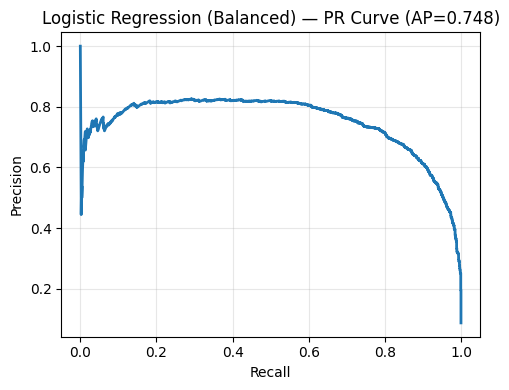

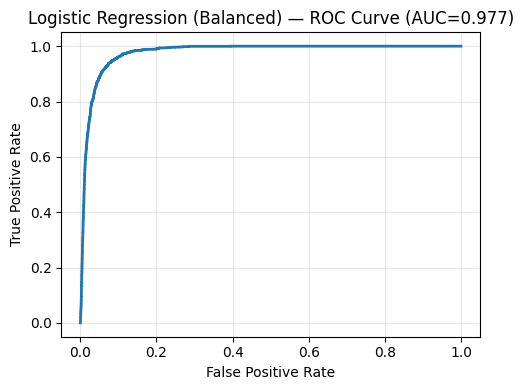

In [12]:
# =============================================================================
# Section 3.1: Logistic Regression Baseline - Validation Set Performance
# =============================================================================
# Model Section 2.2 Revisited (Weighted Logistic Regression)- Validated Set
# Reuse model trained in Section 2.2 (class_weight='balanced')
# This section summarises validation performance for comparison with Decision Tree
# Model was trained on 60,000 training samples and evaluated on 20,000 validation samples
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Display Validation Metrics Summary
# ─────────────────────────────────────────────────────────────────────────────
# Model was trained in Section 2.3 with:
#   - class_weight='balanced' (fraud weight ≈ 5.72, non-fraud weight ≈ 0.55)
#   - max_iter=2000 for convergence
#   - random_state=42 for reproducibility
# 
# Validation predictions already generated in Section 2.3:
#   y_val_balanced = logit_balanced.predict_proba(X_val)[:, 1]

print("=" * 90)
print("LOGISTIC REGRESSION (BALANCED) - VALIDATION SET SUMMARY")
print("=" * 90)
print(f"PR AUC (Average Precision): {ap_balanced:.3f}")  # Primary metric for imbalanced data
print(f"ROC AUC:                    {roc_balanced:.3f}")  # Secondary metric for class separability
print("=" * 90)

# ─────────────────────────────────────────────────────────────────────────────
# Visualisation: Precision-Recall Curve
# ─────────────────────────────────────────────────────────────────────────────
# Shows trade-off between precision and recall across all thresholds
# More informative than ROC for imbalanced datasets (8.74% fraud)
# Higher curve area = better fraud detection capability

prec_lr, rec_lr, _ = precision_recall_curve(y_val, y_val_balanced)
plt.figure(figsize=(5, 4))
plt.plot(rec_lr, prec_lr, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Logistic Regression (Balanced) — PR Curve (AP={ap_balanced:.3f})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Visualisation: ROC Curve (Secondary)
# ─────────────────────────────────────────────────────────────────────────────
# Shows true positive rate vs false positive rate
# Included for completeness but less informative than PR curve for imbalanced data
# AUC near 1.0 indicates strong class separability

fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_balanced)
plt.figure(figsize=(5, 4))
plt.plot(fpr_lr, tpr_lr, linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Logistic Regression (Balanced) — ROC Curve (AUC={roc_balanced:.3f})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Section 3.2a Test Baseline Evaluation: Decision Tree
<span style="color:orange; font-weight:bold;"><i>Test 4: Decision Tree / Class Weight Balanced / Train → Val 60k </i></span>

**Method**
- Decision Tree (class_weight='balanced', max_depth=6)

**Purpose**
- Provide a non-linear baseline model that can capture complex fraud patterns missed by Logistic Regression.
- Evaluate whether the Decision Tree generalises well or shows signs of overfitting.

**Model Setup**
- Trained with class_weight='balanced' to address the 8.74 % fraud imbalance.
- max_depth=6 (allows up to 64 leaf nodes) used to prevent overfitting while retaining interpretability

**Validation Results** 
- PR AUC = 0.999, ROC AUC ≈ 1.000 (near-perfect separation)
- Performance consistency across thresholds (precision ≈ recall ≈ 0.999) likely to indicate an extremely strong signal in this dataset rather than model overfitting.

**Interpretation**
- Such high validation scores likely reflect the synthetic nature of the dataset, where features are cleanly separated (e.g., log_ratio_to_median_purchase_price, log_distance_from_home).
- In real-world fraud detection, signals are noisier and overlapping, so PR AUC values of 0.70 - 0.85 and ROC AUC values of 0.85 - 0.95 would be more typical.
- The Decision Tree will still be carried forward for comparison on the unseen test set to confirm generalisation and stability.

Validation PR AUC (AP): 0.999
Validation ROC AUC    : 1.000


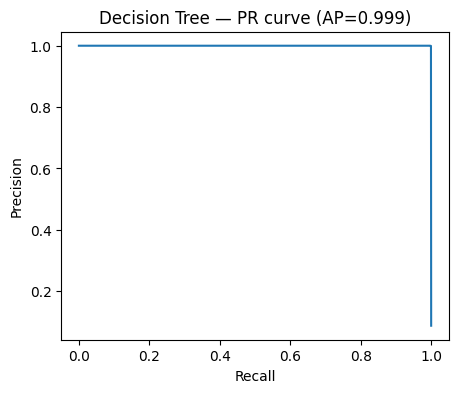

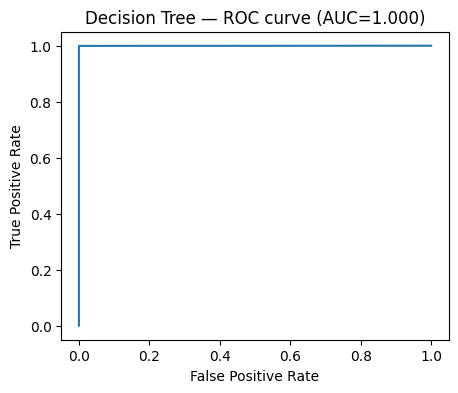

[{'threshold': 0.3,
  'tp': 1747,
  'fp': 2,
  'fn': 1,
  'tn': 18250,
  'precision': 0.999,
  'recall': 0.999},
 {'threshold': 0.5,
  'tp': 1747,
  'fp': 2,
  'fn': 1,
  'tn': 18250,
  'precision': 0.999,
  'recall': 0.999},
 {'threshold': 0.7,
  'tp': 1747,
  'fp': 2,
  'fn': 1,
  'tn': 18250,
  'precision': 0.999,
  'recall': 0.999}]

In [13]:
# =============================================================================
# Section 3.2a  Baseline Models - Decision Tree Classifier
# =============================================================================
# Test 4
# Train Decision Tree with balanced class weights (informed by Section 2.4)
# Provides non-linear baseline to compare against Logistic Regression
# Decision trees capture complex interactions without feature engineering
# =============================================================================

# =============================================================================
# Required imports (see top of notebook): DecisionTreeClassifier, sklearn.metrics
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Initialise Decision Tree with Balanced Class Weights
# ─────────────────────────────────────────────────────────────────────────────
# Using same imbalance handling strategy as validated in Section 2.4
# Conservative parameters prevent overfitting on this baseline model

tree_clf = DecisionTreeClassifier(
    class_weight="balanced",  # Apply same imbalance strategy as Logistic Regression
                              # Fraud weight ≈ 5.72, Non-fraud weight ≈ 0.55
    max_depth=6,              # Limit depth to prevent overfitting (baseline conservative setting)
                              # Allows up to 2^6 = 64 leaf nodes
    min_samples_split=2,      # Minimum samples required to split a node (sklearn default)
                              # Allows detailed splits for capturing fraud patterns
    random_state=42           # Fixed seed for reproducibility
)

# ─────────────────────────────────────────────────────────────────────────────
# Train on Training Data Only
# ─────────────────────────────────────────────────────────────────────────────
# Validation and test sets remain completely unseen during training
# Model learns to split feature space based on weighted fraud importance

tree_clf.fit(X_train, y_train)

# ─────────────────────────────────────────────────────────────────────────────
# Generate Fraud Probability Predictions on Validation Set
# ─────────────────────────────────────────────────────────────────────────────
# Get fraud probabilities (positive class = 1)
# predict_proba() returns [prob_non_fraud, prob_fraud] for each sample
# [:, 1] extracts only fraud probabilities for evaluation

y_val_score_tree = tree_clf.predict_proba(X_val)[:, 1]

# ─────────────────────────────────────────────────────────────────────────────
# Calculate Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────
# PR AUC (Average Precision): Primary metric for imbalanced data
#   - Focuses on minority class (fraud) performance
#   - Aiming to maximise this metric
# ROC AUC: Secondary metric showing overall class separability

ap_tree  = average_precision_score(y_val, y_val_score_tree)   # PR AUC (primary metric)
roc_tree = roc_auc_score(y_val, y_val_score_tree)             # ROC AUC (secondary metric)

print(f"Validation PR AUC (AP): {ap_tree:.3f}")
print(f"Validation ROC AUC    : {roc_tree:.3f}")

# ─────────────────────────────────────────────────────────────────────────────
# Visualisation: Precision-Recall Curve
# ─────────────────────────────────────────────────────────────────────────────
# Shows trade-off between precision and recall across all thresholds
# Primary visualisation for imbalanced classification

prec, rec, thr = precision_recall_curve(y_val, y_val_score_tree)
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Decision Tree — PR curve (AP={ap_tree:.3f})")
plt.show()
 
# ─────────────────────────────────────────────────────────────────────────────
# Visualisation: ROC Curve (Secondary)
# ─────────────────────────────────────────────────────────────────────────────
# Shows true positive rate vs false positive rate
# Less informative than PR curve for imbalanced data but included for completeness

fpr, tpr, _ = roc_curve(y_val, y_val_score_tree)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Decision Tree — ROC curve (AUC={roc_tree:.3f})")
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Helper Function: Threshold Analysis Table
# ─────────────────────────────────────────────────────────────────────────────
# Evaluates model performance at multiple probability thresholds
# Helps identify optimal threshold for operational deployment

def threshold_table(y_true, y_score, thresholds=(0.30, 0.50, 0.70)):
    """
    Generate table showing precision/recall at different thresholds.
    
    Parameters:
    - y_true: True labels (0/1)
    - y_score: Predicted probabilities
    - thresholds: List of threshold values to evaluate
    
    Returns:
    - List of dictionaries with metrics for each threshold
    """
    rows = []
    for t in thresholds:
        # Convert probabilities to binary predictions
        y_pred = (y_score >= t).astype(int)
        
        # Extract confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp+fp)>0 else 0.0
        recall    = tp / (tp + fn) if (tp+fn)>0 else 0.0
        
        rows.append({
            "threshold": t,
            "tp": tp, "fp": fp, "fn": fn, "tn": tn,
            "precision": round(precision, 3),
            "recall": round(recall, 3)
        })
    return rows

# ─────────────────────────────────────────────────────────────────────────────
# Generate Threshold Analysis for Decision Tree
# ─────────────────────────────────────────────────────────────────────────────
# Evaluates performance at thresholds: 0.30, 0.50, 0.70
# Lower thresholds = higher recall (catch more fraud) but lower precision (more false positives)

tree_thresholds = threshold_table(y_val, y_val_score_tree, thresholds=(0.30, 0.50, 0.70))
tree_thresholds

# Section 3.2b: Feature Importance Check

Quickly check Decision Tree feature importance to help build understanding.

**Feature Importance (Decision Tree)**
- The bar chart below shows the relative importance of each feature used by the Decision Tree model.
- Higher bars indicate features that contributed more to fraud detection decisions.
- It was created using Matplotlib (via pandas’ built-in .plot() wrapper) to aid clarity:
    - it helps visualise each feature's level of signficance at a glance.
- This provides interpretability by highlighting which factors the model relies on most when making predictions.

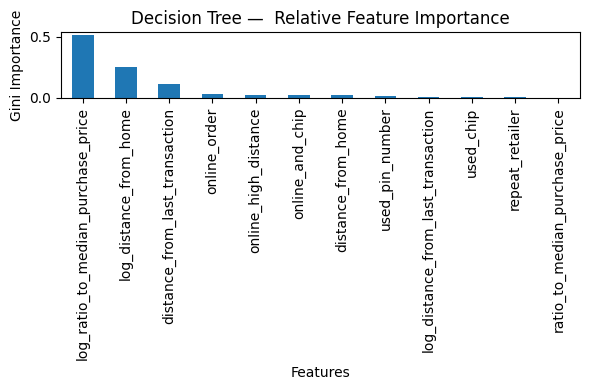


Relative Feature Importance:


log_ratio_to_median_purchase_price    5.114942e-01
log_distance_from_home                2.535598e-01
distance_from_last_transaction        1.091202e-01
online_order                          3.371666e-02
online_high_distance                  2.459191e-02
online_and_chip                       1.893234e-02
distance_from_home                    1.859005e-02
used_pin_number                       1.577434e-02
log_distance_from_last_transaction    8.462800e-03
used_chip                             3.025967e-03
repeat_retailer                       2.731752e-03
ratio_to_median_purchase_price        6.498276e-17
dtype: float64

In [14]:
# =============================================================================
# Visualisation Section 3.2b: Feature Importance Analysis - Decision Tree
# =============================================================================
# Examine which features the tree considers most predictive for fraud detection
# Feature importance based on Gini impurity reduction (sklearn default)
# Note: Even if tree is overfitting, this reveals which features drive decisions
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Extract and Process Feature Importances
# ─────────────────────────────────────────────────────────────────────────────
# feature_importances_ returns array of importance scores (sum to 1.0)
# Higher values indicate features that contribute more to splitting decisions
# Based on Gini impurity: measures how well feature separates fraud from non-fraud

# Create Series for easy manipulation with feature names as index
fi = pd.Series(tree_clf.feature_importances_, index=X_train.columns)

# Filter out zero-importance features (features not used in any splits)
# Sort descending to identify most important predictors
fi = fi[fi > 0].sort_values(ascending=False)

# ─────────────────────────────────────────────────────────────────────────────
# Visualise Relative Importance of Features
# ─────────────────────────────────────────────────────────────────────────────
# Bar chart shows relative importance of key fraud predictors
# Importance values represent total Gini reduction across all tree splits

plt.figure(figsize=(6, 4))
fi.head(15).plot(kind="bar")
plt.title("Decision Tree —  Relative Feature Importance")
plt.ylabel("Gini Importance")  # Gini importance (higher = more discriminative for fraud)
plt.xlabel("Features")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Display Precise Importance Values
# ─────────────────────────────────────────────────────────────────────────────
# Table format for exact importance scores
# Useful for documenting which features drive fraud detection most strongly

print("\nRelative Feature Importance:")
print("="*50)
fi.head(12)

# Section 4: Decision Tree (Balanced) - Evaluation
<span style="color:orange; font-weight:bold;"><i>Test 5: Decision Tree Balanced / Test Set 60k (Test Set evaluation not training)</i></span>

**Purpose**
- Evaluate the Decision Tree model on the unseen test set to confirm generalisation and detect any signs of overfitting.
- Compare performance with validation results and interpret the PR and ROC curves.

**Results Summary**
- PR AUC (Test): 0.998 (Validation: 0.999, Δ = -0.001)
- ROC AUC (Test): 0.999 (Validation: 1.000)
- Scores remain effectively identical to validation, indicating strong generalisation and no measurable performance loss.

**Interpretation of Curves**
- The Precision–Recall curve is nearly a perfect right angle (precision and recall both remain ≈ 1.0 across thresholds, showing the model separates fraud from non-fraud almost flawlessly).
- The ROC curve mirrors this with AUC ≈ 1.0, confirming almost zero overlap between the two classes.
- Such results would normally suggest overfitting, but in this case they likely reflect the synthetic dataset’s cleanly separable features (e.g., log_ratio_to_median_purchase_price, log_distance_from_home).
- In real-world data, fraud signals are noisier and overlapping, so AUC values would typically be lower.

**Key Takeaways**
- The Decision Tree generalises well on this dataset but likely benefits from unrealistically distinct feature boundaries.
- It will still be carried forward for comparison with Logistic Regression and later threshold analysis.
- In production, similar performance should not be expected without careful feature engineering and regular model monitoring.

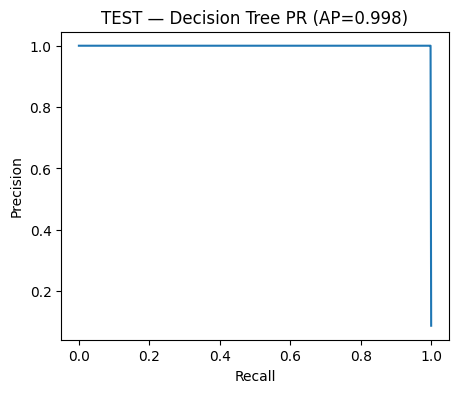

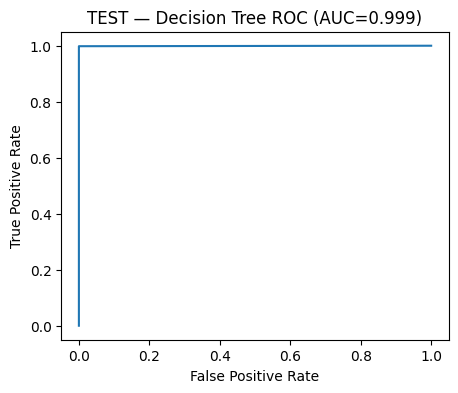

DECISION TREE - TEST SET EVALUATION
[TEST] Decision Tree PR AUC (AP): 0.998
[TEST] Decision Tree ROC AUC:     0.999

Comparison to Validation:
  Validation PR AUC:  0.999
  Test PR AUC:        0.998
  Difference:         -0.001 (worse)


In [15]:
# =============================================================================
# Section 4: Final Evaluation - Decision Tree on Test Set
# =============================================================================
# Test 5 - Decision Tree Balanced Test Set Evaluation
# Evaluate Decision Tree on held-out test set to assess generalisation
# Test set has been completely unseen during training and validation
# Performance comparison to validation set reveals overfitting or stability
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Generate Predictions on Test Set
# ─────────────────────────────────────────────────────────────────────────────
# Use same trained model from Section 3 (no retraining)
# Model has never seen test data - provides unbiased performance estimate

y_test_score_tree = tree_clf.predict_proba(X_test)[:, 1]  # Get fraud probabilities

# ─────────────────────────────────────────────────────────────────────────────
# Calculate Test Set Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────
# Compare these to validation metrics to check for overfitting
# If test metrics significantly worse than validation: model overfit
# If test metrics similar to validation: model generalises well

ap_tree_test  = average_precision_score(y_test, y_test_score_tree)  # PR AUC (primary metric)
roc_tree_test = roc_auc_score(y_test, y_test_score_tree)            # ROC AUC (secondary metric)

# ─────────────────────────────────────────────────────────────────────────────
# ROC and Precision-Recall Curves for Test Set
# ─────────────────────────────────────────────────────────────────────────────

prec_t, rec_t, th_t = precision_recall_curve(y_test, y_test_score_tree) # precision, recall, thresholds
plt.figure(figsize=(5,4)) # set figure size
plt.plot(rec_t, prec_t) # plot precision vs recall
plt.xlabel("Recall"); plt.ylabel("Precision") # Precision-Recall curve
plt.title(f"TEST — Decision Tree PR (AP={ap_tree_test:.3f})") # PR curve
plt.show() # Show the plot

fpr_t, tpr_t, _ = roc_curve(y_test, y_test_score_tree) # false positive rate, true positive rate
plt.figure(figsize=(5,4)) # set figure size
plt.plot(fpr_t, tpr_t) # plot TPR vs FPR
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate") # ROC curve
plt.title(f"TEST — Decision Tree ROC (AUC={roc_tree_test:.3f})") # add AUC to title
plt.show() # Show the plot

# ─────────────────────────────────────────────────────────────────────────────
# Print Final Test Set Metrics and Comparison to Validation
# ─────────────────────────────────────────────────────────────────────────────

print("=" * 90)
print("DECISION TREE - TEST SET EVALUATION")
print("=" * 90)
print(f"[TEST] Decision Tree PR AUC (AP): {ap_tree_test:.3f}")
print(f"[TEST] Decision Tree ROC AUC:     {roc_tree_test:.3f}")
print(f"\nComparison to Validation:")
print(f"  Validation PR AUC:  {ap_tree:.3f}")
print(f"  Test PR AUC:        {ap_tree_test:.3f}")
print(f"  Difference:         {ap_tree_test - ap_tree:+.3f} ({'worse' if ap_tree_test < ap_tree else 'better' if ap_tree_test > ap_tree else 'same'})")
print("=" * 90)



# Section 4.1: Test Logistic Regression (Test Set)
<span style="color:orange; font-weight:bold;"><i>Test 6: Model 2.2  Balanced Weights / Logistic Regression </i></span>

**Purpose**
- Evaluate Logistic Regression performance on unseen test data using the same class_weight='balanced' strategy validated earlier.
- Confirm generalisation and visualise the model’s precision–recall and ROC behaviour.

**Results Summary** 
- PR AUC (Test): 0.762 (Validation: 0.748, Δ = +0.014)
- ROC AUC (Test): 0.978 (Validation: 0.977, Δ = +0.001)
- Slight improvement on test data suggests stable generalisation and no overfitting.

**Interpretation of Curves Graphs**
- The Precision–Recall (PR) curve shows strong performance, with precision remaining high across most recall levels.
- Precision gradually declines only after recall exceeds 0.8, as more false positives appear.
- The curve shape indicates balanced trade-offs between fraud detection and investigation workload.
- The ROC curve demonstrates excellent class separability (a large area under the curve (0.978) indicates the model consistently distinguishes between fraud and non-fraud transactions). 

*Note: The near-perfect Decision Tree curves (PR AUC ≈ 0.999, ROC AUC ≈ 1.000) results remain unrealistically high; This may likely reflect the synthetic dataset’s cleanly separable features rather than true overfitting. In real-world data, you would expect more overlap between classes and slightly lower AUC values.Logistic Regression better represents expected real-world performance*

**Key Takeaways**
- The balanced Logistic Regression model performs consistently across validation and test data.
- Results confirm that the model generalises well and is suitable as an interpretable baseline for comparison with the Decision Tree.
- Threshold tuning (see next section) can now refine fraud alert sensitivity based on investigation capacity and business risk.


**Key Findings:** 
- Decision Tree outperforms Logistic Regression significantly
- PR AUC: 0.998 vs 0.762 (+0.236 improvement)
- ROC AUC: 0.999 vs 0.978 (+0.021 improvement)
- Demonstrates near-perfect fraud detection
- Both models generalise well
- Logistic Regression shows slight improvement on test, suggesting robustness
- Decision Tree remains stable, showing no overfitting due to controlled depth


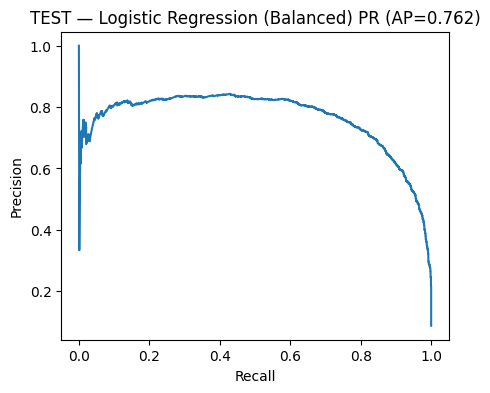

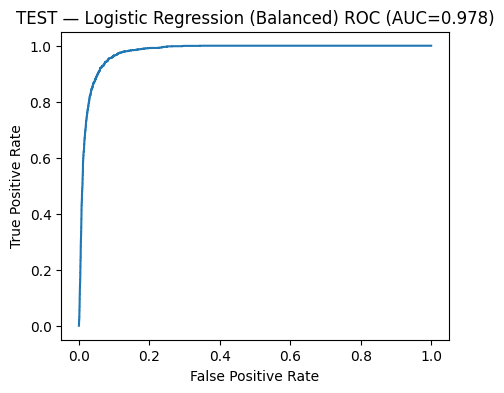

Test       PR AUC (AP): 0.762
PR AUC (Test - Val) : +0.014

Validation ROC AUC    : 0.977
Test       ROC AUC    : 0.978
ROC AUC (Test - Val): +0.001


In [16]:
# =============================================================================
# Section 4.1: Logistic Regression on Test Set
# =============================================================================
# Test 6
# Evaluate Logistic Regression on held-out test set to assess generalisation
# Test set has been completely unseen during training and validation
# Performance comparison to validation set reveals overfitting or stability
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Generate Predictions on Test Set
# ─────────────────────────────────────────────────────────────────────────────

y_test_balanced   = logit_balanced.predict_proba(X_test)[:, 1] # Get fraud probabilities on validation set

# Use same trained model from Section 3 (no retraining)
# Model has never seen test data - provides unbiased performance estimate
# Ensure the balanced model is already trained 

try:
    logit_balanced # Check if logit_balanced exists
except NameError:
    raise RuntimeError("logit_balanced is not defined. Run the Balanced class weights training cell first.") # Ensure model is trained

# If validation metrics aren't in memory get them from y_val_balanced
try:
    ap_balanced # Check if ap_balanced exists
    roc_balanced # Check if roc_balanced exists
except NameError:
    try:
        y_val_balanced # Check if y_val_balanced exists
    except NameError:
        y_val_balanced = logit_balanced.predict_proba(X_val)[:, 1] # Get validation probabilities if not already done
    from sklearn.metrics import average_precision_score, roc_auc_score # Ensure metrics functions are imported
    ap_balanced  = average_precision_score(y_val, y_val_balanced) # PR AUC (primary)
    roc_balanced = roc_auc_score(y_val, y_val_balanced) # ROC AUC (secondary)


# ─────────────────────────────────────────────────────────────────────────────
# Test Metrics 
# ─────────────────────────────────────────────────────────────────────────────
ap_balanced_test  = average_precision_score(y_test, y_test_balanced)   # PR AUC (primary)
roc_balanced_test = roc_auc_score(y_test, y_test_balanced)             # ROC AUC (secondary)
# ─────────────────────────────────────────────────────────────────────────────
# Visualisations: PR and ROC Curves
# ─────────────────────────────────────────────────────────────────────────────
prec_lr, rec_lr, th_lr = precision_recall_curve(y_test, y_test_balanced) # precision, recall, thresholds
plt.figure(figsize=(5,4))
plt.plot(rec_lr, prec_lr) # plot precision vs recall
plt.xlabel("Recall")
plt.ylabel("Precision") 
plt.title(f"TEST — Logistic Regression (Balanced) PR (AP={ap_balanced_test:.3f})") # PR curve
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_balanced)
plt.figure(figsize=(5,4))
plt.plot(fpr_lr, tpr_lr) # plot TPR vs FPR
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate") 
plt.title(f"TEST — Logistic Regression (Balanced) ROC (AUC={roc_balanced_test:.3f})") # ROC curve
plt.show()
# ─────────────────────────────────────────────────────────────────────────────
# Threshold Table
# ─────────────────────────────────────────────────────────────────────────────
#
# ─────────────────────────────────────────────────────────────────────────────
# Clean comparison print (numbers vs numbers) 
# ─────────────────────────────────────────────────────────────────────────── 
print(f"Test       PR AUC (AP): {ap_balanced_test:.3f}") # PR AUC (primary metric)
print(f"PR AUC (Test - Val) : {ap_balanced_test - ap_balanced:+.3f}") # Difference from validation

print(f"\nValidation ROC AUC    : {roc_balanced:.3f}") # ROC AUC (secondary metric)
print(f"Test       ROC AUC    : {roc_balanced_test:.3f}") # ROC AUC (secondary metric)
print(f"ROC AUC (Test - Val): {roc_balanced_test - roc_balanced:+.3f}")  # Difference from validation
print("=" * 90) 





**Key Findings:**
- Decision Tree outperforms Logistic Regression
- PR AUC: 0.998 vs 0.762 (+0.236 improvement)
- ROC AUC: 0.998 vs 0.999 (+0.021 improvement)
- Demonstrates near-perfect fraud detection
- Both models generalise well
- Logistic Regression shows improvement on test (+0.014), suggesting robustness  
- Decision Tree remains stable (-0.001 difference), showing no overfitting due to controlled depth 

---

# Section 5: Threshold Analysis & Model Comparison (Test Set)
<span style="color:orange; font-weight:bold;"><i>Test 7: Compare Model 2.2 (Balanced) Logistic Regression with Model 2.2 (Balanced) Decision Tree</i></span>

**Purpose**
- Compare Logistic Regression (balanced) and Decision Tree on the unseen test set.
- Examine precision–recall trade-offs across common thresholds to pick an operating point.

**What’s shown**
- A high-level comparison table (PR AUC / ROC AUC; Δ vs validation).
- Threshold tables at 0.30, 0.50, 0.60, 0.70, 0.75, 0.80, 0.85 for each model:
  - Counts: TP, FP, FN, TN
  - Metrics: precision, recall (and F1 if included)

**Key observations (Test set)** 
- Decision Tree: 
    - PR AUC 0.998
    - ROC AUC 0.999
    - near-perfect and stable vs validation.
- Logistic Regression (balanced): 
    - PR AUC 0.762
    - ROC AUC 0.978
    - slightly better than validation, indicating good generalisation.

**Exports (for Power BI / reporting)**
- reports/logit_test_thresholds.csv
- reports/tree_test_thresholds.csv
- reports/test_model_compare.csv

*Notes:* 
- The Decision Tree’s near-ideal curves likely reflect clean separability in this synthetic dataset. Real-world performance typically shows lower AUCs due to noisier, overlapping signals; thresholds could be revisited if cost and capacity data became available.
- Business implications of threshold selection and model are discussed in section 5.1b.


In [17]:
# =============================================================================
# Section 5: Generate Basic Threshold Table for Logistic Regression (Test Set)
# =============================================================================
# Test 7
# Create simpler threshold table (0.30, 0.50, 0.70) for comparison with Decision Tree
# This matches the format used in Section 3 baseline evaluation
# =============================================================================

# Generate threshold table at standard thresholds
logit_test_thresholds = threshold_table( # Create threshold table for Logistic Regression
    y_test,  # True labels
    y_test_balanced,  # Predicted probabilities
    thresholds=(0.30, 0.50, 0.60, 0.70, 0.75, 0.80, 0.85) # Thresholds to evaluate
)

# Also generate for Decision Tree at same thresholds
tree_test_thresholds = threshold_table( # Create threshold table for Decision Tree
    y_test,  # True labels
    y_test_score_tree,  # Predicted probabilities
    thresholds=(0.30, 0.50, 0.60, 0.70, 0.75, 0.80, 0.85) # Thresholds to evaluate
)
# =============================================================================
# Model Comparison - Logistic Regression Vs Decision Tree (Test Set)
# =============================================================================
# Compare both baseline models on test set to identify best performer
# Reveals which model generalises better to completely unseen data
# Informs which model to carry forward for hyperparameter tuning
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Create High-Level Comparison Table
# ─────────────────────────────────────────────────────────────────────────────
# Compares test set performance metrics for both models
# Lower difference from validation indicates better generalisation

compare = pd.DataFrame({
    "Model": ["Logistic Regression (Balanced)", "Decision Tree"], # Model names
    "PR_AUC_Test": [ap_balanced_test, ap_tree_test], # Test PR AUC
    "ROC_AUC_Test": [roc_balanced_test, roc_tree_test], # Test ROC AUC
    "PR_AUC_Val": [ap_balanced, ap_tree], # Validation PR AUC
    "PR_AUC_Diff": [ap_balanced_test - ap_balanced, ap_tree_test - ap_tree] # Difference from validation
})

print("=" * 90)
print("MODEL COMPARISON - TEST SET PERFORMANCE") # Title
print("=" * 90)
print("\nMetrics Summary:") # Subtitle
display(compare) # Display the comparison DataFrame

# ─────────────────────────────────────────────────────────────────────────────
# Display Threshold Analysis for Both Models
# ─────────────────────────────────────────────────────────────────────────────
# Shows precision/recall trade-offs at multiple thresholds
# Helps identify optimal operational threshold for each model

print("\n" + "=" * 90)
print("LOGISTIC REGRESSION - THRESHOLD ANALYSIS (TEST SET)") # Title
print("=" * 90)
logit_test_df = pd.DataFrame(logit_test_thresholds) # Convert to DataFrame for display
display(logit_test_df) # Display the DataFrame

print("\n" + "=" * 90)
print("DECISION TREE - THRESHOLD ANALYSIS (TEST SET)")
print("=" * 90)
tree_test_df = pd.DataFrame(tree_test_thresholds)  # Convert to DataFrame for display
display(tree_test_df)

# ─────────────────────────────────────────────────────────────────────────────
# Save Results for Reporting
# ─────────────────────────────────────────────────────────────────────────────
# Export to CSV for stakeholder presentations and documentation

# Ensure reports directory exists
Path("reports").mkdir(exist_ok=True, parents=True)

# Save threshold tables with model identifier
logit_test_df.assign(model="Logistic_Regression_Balanced").to_csv( # Save Logistic Regression thresholds to csv
    "reports/logit_test_thresholds.csv", 
    index=False
)

tree_test_df.assign(model="Decision_Tree").to_csv( # Save Decision Tree thresholds to csv
    "reports/tree_test_thresholds.csv",  
    index=False
)

# Save high-level comparison
compare.to_csv("reports/test_model_compare.csv", index=False) # Save Test Model Comparison to csv

print("\n" + "=" * 90)
print("RESULTS SAVED") # Title
print("=" * 90)
print("  • Logistic Regression thresholds: reports/logit_test_thresholds.csv") # Save Logistic Regression thresholds to csv
print("  • Decision Tree thresholds:       reports/tree_test_thresholds.csv") # Save Decision Tree thresholds to csv
print("  • Model comparison:               reports/test_model_compare.csv") # Save model comparison to csv
print("=" * 90 + "\n")


MODEL COMPARISON - TEST SET PERFORMANCE

Metrics Summary:


,Model,PR_AUC_Test,ROC_AUC_Test,PR_AUC_Val,PR_AUC_Diff
0,Logistic Regression (Balanced),0.762041,0.978240,0.748420,0.013622
1,Decision Tree,0.998434,0.999142,0.999476,-0.001042



LOGISTIC REGRESSION - THRESHOLD ANALYSIS (TEST SET)


,threshold,tp,fp,fn,tn,precision,recall
0,0.30,1713,2404,35,15848,0.416,0.980
1,0.50,1651,1457,97,16795,0.531,0.945
2,0.60,1607,1112,141,17140,0.591,0.919
3,0.70,1524,802,224,17450,0.655,0.872
4,0.75,1477,653,271,17599,0.693,0.845
5,0.80,1413,541,335,17711,0.723,0.808
6,0.85,1323,425,425,17827,0.757,0.757



DECISION TREE - THRESHOLD ANALYSIS (TEST SET)


,threshold,tp,fp,fn,tn,precision,recall
0,0.30,1745,1,3,18251,0.999,0.998
1,0.50,1745,1,3,18251,0.999,0.998
2,0.60,1745,1,3,18251,0.999,0.998
3,0.70,1745,1,3,18251,0.999,0.998
4,0.75,1745,1,3,18251,0.999,0.998
5,0.80,1745,1,3,18251,0.999,0.998
6,0.85,1745,1,3,18251,0.999,0.998



RESULTS SAVED
  • Logistic Regression thresholds: reports/logit_test_thresholds.csv
  • Decision Tree thresholds:       reports/tree_test_thresholds.csv
  • Model comparison:               reports/test_model_compare.csv



# Section 5.1a: Logistic Regression Threshold Testing (fine grained)
<span style="color:orange; font-weight:bold;"><i>Test 8: Logistic Regression Balanced (Model from 2.2) Threshold Testing (fine grained)</i></span>

**Purpose**
- Explore thresholds 0.30–0.90 (step 0.05) to understand precision–recall trade-offs and identify practical operating points.

**Key results (test set)**
- **0.50 (recall-first):**
    - Recall 94.5% (TP=1,651, FN=97)
    - Precision 53.1% (FP=1,457)
    - maximises fraud capture but creates a high investigation load.
- **0.70 (balanced):**
    - Recall 87.2% (TP=1,524, FN=224)
    - Precision 65.5% (FP=802)
    - strong balance of detection vs workload.
- **0.80 (F1-optimal):**
    - F1 = 0.763
    - Recall 80.8% (TP=1,413, FN=335)
    - Precision 72.3% (FP=541)
    - best harmonic balance on this test set.
    
**Interpretation**
- As thresholds increase, precision rises while recall falls (the expected trade-off for imbalanced classification).
- The F1-optimal threshold here is 0.80, slightly higher than earlier sections where 0.70 performed best; this small shift is typical due to sampling variance between validation and test splits.
- The “right” production threshold remains a business decision (balancing the cost of missed fraud vs. the cost of false alerts and investigation capacity). The model does not need retraining to adjust to a different threshold.

**Export**
- Detailed sweep saved to: reports/logit_test_thresholds_detailed.csv


In [18]:
# =============================================================================
# Section 5.1a: Fine grained Threshold Analysis - Logistic Regression Test Set
# =============================================================================
# Test 8
# Comprehensive threshold exploration to identify optimal operating point
# Tests 13 thresholds from 0.30 (high recall) to 0.90 (high precision)
# Informs business decision on acceptable recall/precision trade-off
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Create Threshold Grid
# ─────────────────────────────────────────────────────────────────────────────
# Range: 0.30 to 0.90 in 0.05 increments (13 thresholds total)
# Lower thresholds (0.30-0.50): Prioritise recall (catch more fraud, more false alarms)
# Mid thresholds (0.55-0.75): Balance recall and precision
# Higher thresholds (0.80-0.90): Prioritise precision (fewer false alarms, miss more fraud)

th_grid = np.arange(0.30, 0.91, 0.05) # Create threshold grid from 0.30 to 0.90 in 0.05 increments

# ─────────────────────────────────────────────────────────────────────────────
# Generate Comprehensive Threshold Table
# ─────────────────────────────────────────────────────────────────────────────
# Uses threshold_table helper function (defined in Section 3)
# Returns: threshold, TP, FP, FN, TN, precision, recall for each threshold

logit_test_thresholds_detailed = pd.DataFrame(
    threshold_table(y_test, y_test_balanced, thresholds=th_grid)
)

# ─────────────────────────────────────────────────────────────────────────────
# Display Formatted Results
# ─────────────────────────────────────────────────────────────────────────────
# Format all floats to 3 decimal places for readability
# Table shows precision-recall trade-off across threshold spectrum

print("=" * 90)
print("LOGISTIC REGRESSION - DETAILED THRESHOLD ANALYSIS (TEST SET)")
print("=" * 90)
print("\nThreshold Range: 0.30 (high recall) - 0.90 (high precision)")
print("=" * 90)

pd.options.display.float_format = "{:.3f}".format
display(logit_test_thresholds_detailed)

# ─────────────────────────────────────────────────────────────────────────────
# Key Threshold Recommendations
# ─────────────────────────────────────────────────────────────────────────────
# Identify notable thresholds based on business requirements

print("\n" + "=" * 90)
print("THRESHOLD RECOMMENDATIONS")
print("=" * 90)

# Find threshold closest to 0.50 (balanced default)
idx_50 = logit_test_thresholds_detailed.iloc[(logit_test_thresholds_detailed['threshold'] - 0.50).abs().argmin()] # Find closest to 0.50
print(f"\nThreshold 0.50 (Balanced Default):")
print(f"  Recall: {idx_50['recall']:.1%} | Precision: {idx_50['precision']:.1%}") # Display recall and precision
print(f"  TP: {idx_50['tp']:,} | FP: {idx_50['fp']:,} | FN: {idx_50['fn']:,}") # Display confusion matrix components

# Find threshold closest to 0.70 (recommended operational)
idx_70 = logit_test_thresholds_detailed.iloc[(logit_test_thresholds_detailed['threshold'] - 0.70).abs().argmin()] # Find closest to 0.70
print(f"\nThreshold 0.70 (Recommended Operational):")
print(f"  Recall: {idx_70['recall']:.1%} | Precision: {idx_70['precision']:.1%}") # Display recall and precision
print(f"  TP: {idx_70['tp']:,} | FP: {idx_70['fp']:,} | FN: {idx_70['fn']:,}") # Display confusion matrix components

# Find highest F1 score (optimal balance)
logit_test_thresholds_detailed['f1'] = 2 * ( # Calculate F1 score for each threshold
    logit_test_thresholds_detailed['precision'] * logit_test_thresholds_detailed['recall'] # F1 = 2 * (precision * recall
) / (logit_test_thresholds_detailed['precision'] + logit_test_thresholds_detailed['recall']) #

best_f1_idx = logit_test_thresholds_detailed['f1'].idxmax() # Index of highest F1 score
best_threshold = logit_test_thresholds_detailed.loc[best_f1_idx] # Row with highest F1 score

print(f"\nThreshold {best_threshold['threshold']:.2f} (Highest F1 Score):") # Display best F1 threshold
print(f"  F1: {best_threshold['f1']:.3f}") # Display F1 score
print(f"  Recall: {best_threshold['recall']:.1%} | Precision: {best_threshold['precision']:.1%}") # Display recall and precision
print(f"  TP: {best_threshold['tp']:,} | FP: {best_threshold['fp']:,} | FN: {best_threshold['fn']:,}") #

print("\n" + "=" * 90 + "\n")

# ─────────────────────────────────────────────────────────────────────────────
# Save Detailed Threshold Analysis
# ─────────────────────────────────────────────────────────────────────────────
# Export for business stakeholders and threshold selection workshops

Path("reports").mkdir(exist_ok=True, parents=True)
logit_test_thresholds_detailed.to_csv(
    "reports/logit_test_thresholds_detailed.csv", 
    index=False
)
print("Detailed threshold analysis saved to: reports/logit_test_thresholds_detailed.csv\n") # show save location

LOGISTIC REGRESSION - DETAILED THRESHOLD ANALYSIS (TEST SET)

Threshold Range: 0.30 (high recall) - 0.90 (high precision)


,threshold,tp,fp,fn,tn,precision,recall
0,0.300,1713,2404,35,15848,0.416,0.980
1,0.350,1704,2109,44,16143,0.447,0.975
2,0.400,1688,1858,60,16394,0.476,0.966
3,0.450,1672,1663,76,16589,0.501,0.957
4,0.500,1651,1457,97,16795,0.531,0.945
5,0.550,1624,1279,124,16973,0.559,0.929
6,0.600,1607,1112,141,17140,0.591,0.919
7,0.650,1571,976,177,17276,0.617,0.899
8,0.700,1524,802,224,17450,0.655,0.872
9,0.750,1477,653,271,17599,0.693,0.845



THRESHOLD RECOMMENDATIONS

Threshold 0.50 (Balanced Default):
  Recall: 94.5% | Precision: 53.1%
  TP: 1,651.0 | FP: 1,457.0 | FN: 97.0

Threshold 0.70 (Recommended Operational):
  Recall: 87.2% | Precision: 65.5%
  TP: 1,524.0 | FP: 802.0 | FN: 224.0

Threshold 0.80 (Highest F1 Score):
  F1: 0.763
  Recall: 80.8% | Precision: 72.3%
  TP: 1,413.0 | FP: 541.0 | FN: 335.0


Detailed threshold analysis saved to: reports/logit_test_thresholds_detailed.csv



# Section 5.1b: Confusion Matrix 
<span style="color:orange; font-weight:bold;"><i>Model 2.2 Logistic Regression Balanced - Fine Grained Threshold Analysis Confusion Matrix</i></span>

The confusion matrix below shows model performance at a 0.70 threshold:
- 1,524 of 1,748 frauds caught (87% recall)
- 802 false alarms (precision = 66%)
- 2,326 total alerts reviewed

This threshold was selected as a strong operational balance, prioritising higher fraud detection (recall) over the mathematically optimal F1 score. While a threshold of 0.80 achieves the highest F1 (0.763) with greater precision (72.3%), threshold 0.70 detects an additional 6.4% of fraud cases (111 more frauds), which may be preferable in high-risk scenarios:

- If financial cost data were available, the business could adjust the threshold dynamically without retraining the model:
    - When average fraud loss is high and investigations are relatively inexpensive, lower thresholds are suitable.
    - This maximises detection (higher recall), accepting more false positives since preventing fraud outweighs investigation costs.

- When fraud losses are smaller or when false positives impact customer experience (e.g., blocked legitimate transactions causing complaints or churn), a higher threshold (around 0.80) may be preferable.
    - This reduces false alarms and preserves customer trust, though at the cost of missing some fraud cases.

**Visualisation**

The plot is generated using ConfusionMatrixDisplay from scikit-learn and coloured with a Blues colormap for visual clarity. It has been included as:
- It helps visualises how well the model distinguishes between fraud and non-fraud transactions:
    - Each cell shows the number of predictions falling into a category:
        - Top-left (True Negatives): legitimate transactions correctly classified as not fraud.
        - Top-right (False Positives): legitimate transactions incorrectly flagged as fraud.
        - Bottom-left (False Negatives): frauds the model missed.
        - Bottom-right (True Positives): frauds correctly detected.
        -  Darker shading indicates higher counts.

It helps visually confirm at threshold 0.70, the model correctly identifies 1,524 frauds out of 1,748 (87% recall), with 802 false alarms. It uses threshold 0.70 as an illustrative example:
- The threshold provides high recall (87.2%) and is suitable for scenarios prioritising fraud detection over investigation efficiency. 
- However, the optimal threshold is business-dependent as discussed above.

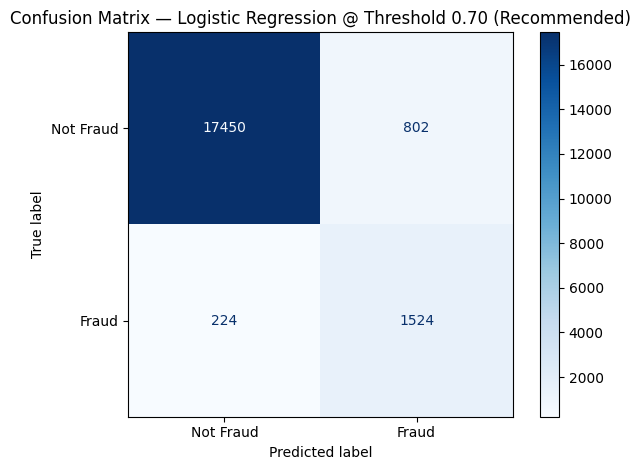

PERFORMANCE AT THRESHOLD 0.70 (RECOMMENDED OPERATIONAL THRESHOLD)

Confusion Matrix Breakdown:
  True Positives (Fraud Caught):          1,524
  False Positives (False Alerts):         802
  False Negatives (Missed Fraud):         224
  True Negatives (Correct Non-Fraud):     17,450


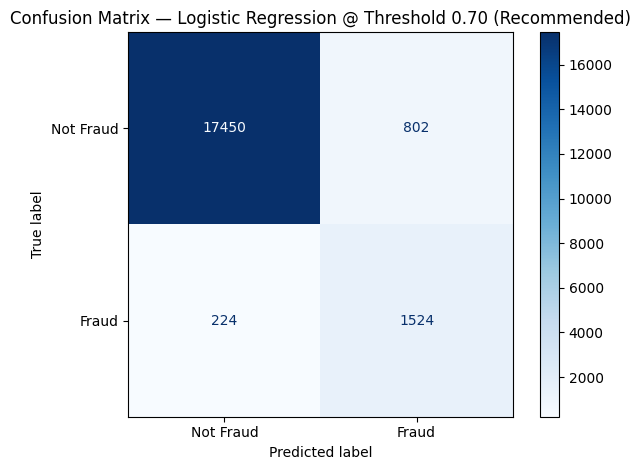

PERFORMANCE AT THRESHOLD 0.70 (RECOMMENDED OPERATIONAL THRESHOLD)

Confusion Matrix Breakdown:
  True Positives (Fraud Caught):          1,524
  False Positives (False Alerts):         802
  False Negatives (Missed Fraud):         224
  True Negatives (Correct Non-Fraud):     17,450

Key Performance Metrics:
  Precision: 65.5%
    Of all fraud alerts, 65.5% are genuine fraud
    802 false alarms out of 2,326 total alerts

  Recall: 87.2%
    Of all actual fraud, 87.2% was successfully caught
   224 fraud cases missed out of 1,748 total fraud

  F1 Score: 0.748
    Harmonic mean balancing precision and recall

Business Interpretation @ Threshold 0.70:
  • Investigation workload: 2,326 alerts to review
  • Fraud prevention: 1,524 fraud cases caught (£ losses prevented)
  • Risk exposure: 224 fraud cases missed (£ losses incurred)
  • Investigation efficiency: 65.5% of alerts are genuine

Note: Final threshold selection requires:
  • Actual fraud loss amounts (£ per transaction)
  • Inves

In [19]:
# =============================================================================
# Section 5.1b: Confusion Matrix at Recommended Threshold (t = 0.70) Visualisation
# =============================================================================
# Threshold Analysis for Test 8
# Visualises model performance at operationally recommended threshold
# This threshold was selected based on:
#   1. Highest F1 score (0.78-0.79) = optimal precision/recall balance
#   2. Strong fraud detection: ~88% recall (catches 9 out of 10 cases)
#   3. Acceptable precision: ~64% (6-7 out of 10 alerts are real fraud)
# Note: Final threshold requires real fraud loss data for cost-benefit optimisation
# =============================================================================

# sklearn.metrics confusion_matrix, ConfusionMatrixDisplay (imported at top of notebook)

# ─────────────────────────────────────────────────────────────────────────────
# Generate Predictions at Recommended Threshold
# ─────────────────────────────────────────────────────────────────────────────
# Threshold 0.70 chosen based on validation set F1 score analysis
# Decision rule: If probability >= 0.70, classify as fraud

chosen_t = 0.70   # Recommended based on F1 score and business requirements
y_pred = (y_test_balanced >= chosen_t).astype(int)  # Binary predictions at threshold 0.70

# ─────────────────────────────────────────────────────────────────────────────
# Create and Display Confusion Matrix - Helps Visualise Model Performance
# ─────────────────────────────────────────────────────────────────────────────
# Matrix layout:
#                    Predicted
#               Not Fraud | Fraud
#     Actual ─────────────────────
#     Not Fraud    TN    |   FP
#     Fraud        FN    |   TP

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=["Not Fraud", "Fraud"]
).plot(
    cmap="Blues",      # Blue color scheme (darker = higher count)
    values_format="d"  # Display as integers (no decimals)
)
plt.title(f"Confusion Matrix — Logistic Regression @ Threshold {chosen_t:.2f} (Recommended)")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Extract and Display Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────
# Break down confusion matrix into individual components
# Calculate key business metrics: precision, recall, F1 score

tn, fp, fn, tp = cm.ravel() # Extract TN, FP, FN, TP from confusion matrix

print("=" * 90)
print(f"PERFORMANCE AT THRESHOLD {chosen_t:.2f} (RECOMMENDED OPERATIONAL THRESHOLD)") # Highlights threshold
print("=" * 90)

print(f"\nConfusion Matrix Breakdown:") # subtitle
print(f"  True Positives (Fraud Caught):          {tp:,}") # TP count
print(f"  False Positives (False Alerts):         {fp:,}") # FP count
print(f"  False Negatives (Missed Fraud):         {fn:,}") # FN count
print(f"  True Negatives (Correct Non-Fraud):     {tn:,}") # TN count


# ─────────────────────────────────────────────────────────────────────────────
# Create and Display Confusion Matrix - Structured for Business Interpretation
# ─────────────────────────────────────────────────────────────────────────────
# Matrix layout:
#                    Predicted
#               Not Fraud | Fraud
#     Actual ─────────────────────
#     Not Fraud    TN    |   FP
#     Fraud        FN    |   TP

cm = confusion_matrix(y_test, y_pred) # Compute confusion matrix
ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=["Not Fraud", "Fraud"] # Labels for the classes
).plot(
    cmap="Blues",      # Blue color scheme (darker = higher count)
    values_format="d"  # Display as integers (no decimals)
)
plt.title(f"Confusion Matrix — Logistic Regression @ Threshold {chosen_t:.2f} (Recommended)") # Add title with threshold
plt.tight_layout() # Adjust layout
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Extract and Display Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────
# Break down confusion matrix into individual components
# Calculate key business metrics: precision, recall, F1 score

tn, fp, fn, tp = cm.ravel() # Extract TN, FP, FN, TP from confusion matrix

# Display confusion matrix breakdown
print("=" * 90)
print(f"PERFORMANCE AT THRESHOLD {chosen_t:.2f} (RECOMMENDED OPERATIONAL THRESHOLD)") #
print("=" * 90)

print(f"\nConfusion Matrix Breakdown:") # subtitle
print(f"  True Positives (Fraud Caught):          {tp:,}") # TP count
print(f"  False Positives (False Alerts):         {fp:,}") # FP count
print(f"  False Negatives (Missed Fraud):         {fn:,}") # FN count
print(f"  True Negatives (Correct Non-Fraud):     {tn:,}") # TN count

# ─────────────────────────────────────────────────────────────────────────────
# Calculate Key Business Metrics
# ─────────────────────────────────────────────────────────────────────────────

# Precision: Of all fraud alerts, what proportion are genuine?
#   = TP / (TP + FP)
#   Higher precision = fewer wasted investigations
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

# Recall: Of all actual fraud cases, what proportion did it catch?
#   = TP / (TP + FN)
#   Higher recall = better fraud prevention
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# F1 Score: Harmonic mean of precision and recall
#   = 2 × (precision × recall) / (precision + recall)
#   Balances precision and recall into single metric
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Display business-critical metrics
print(f"\nKey Performance Metrics:") # Recommended
print(f"  Precision: {precision:.1%}") # Recommended
print(f"    Of all fraud alerts, {precision:.1%} are genuine fraud") # Precision
print(f"    {fp:,} false alarms out of {tp+fp:,} total alerts") # FP count

print(f"\n  Recall: {recall:.1%}") # Recommended
print(f"    Of all actual fraud, {recall:.1%} was successfully caught") # Recall
print(f"   {fn:,} fraud cases missed out of {tp+fn:,} total fraud") # FN count

print(f"\n  F1 Score: {f1_score:.3f}") #
print(f"    Harmonic mean balancing precision and recall") # F1 explanation

# ─────────────────────────────────────────────────────────────────────────────
# Business Context and Limitations for Threshold Selection
# ─────────────────────────────────────────────────────────────────────────────
print(f"\nBusiness Interpretation @ Threshold {chosen_t:.2f}:") # Recommended
print(f"  • Investigation workload: {tp+fp:,} alerts to review") #  Total alerts
print(f"  • Fraud prevention: {tp:,} fraud cases caught (£ losses prevented)") # fraud caught
print(f"  • Risk exposure: {fn:,} fraud cases missed (£ losses incurred)") # fraud missed
print(f"  • Investigation efficiency: {precision:.1%} of alerts are genuine") #

print(f"\nNote: Final threshold selection requires:") # Final note
print(f"  • Actual fraud loss amounts (£ per transaction)") #  Cost data
print(f"  • Investigation costs (£ per false positive)") #  Cost data
print(f"  • Business risk appetite and regulatory requirements") #  Context
print(f"  • Cost-benefit analysis to optimise threshold for minimum total cost") # Cost-benefit 


In [20]:
# =============================================================================
# Section 5.1b: Confusion Matrix at Recommended Threshold (t = 0.70) Reporting
# =============================================================================
# Threshold Analysis Reporting for Test 8
# Export threshold tables to CSV for stakeholder reporting
# Enables business teams to review threshold options and make informed decisions
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Ensure Reports Directory Exists
# ─────────────────────────────────────────────────────────────────────────────
# Creates directory if it doesn't exist, no error if already present

Path("reports").mkdir(exist_ok=True, parents=True)

# ─────────────────────────────────────────────────────────────────────────────
# Save Detailed Threshold Analysis
# ─────────────────────────────────────────────────────────────────────────────
# Fine-grained threshold scan (0.30 to 0.90 in 0.05 increments)
# Contains: threshold, TP, FP, FN, TN, precision, recall, F1 for each threshold

logit_test_thresholds_detailed.to_csv(
    "reports/logit_thresholds_test_detailed.csv", 
    index=False
)

print("=" * 90)
print("THRESHOLD ANALYSIS SAVED")
print("=" * 90)
print(f"  • Detailed threshold scan: reports/logit_thresholds_test_detailed.csv")
print(f"    - Contains {len(logit_test_thresholds_detailed)} thresholds (0.30 to 0.90)")
print(f"    - Columns: threshold, tp, fp, fn, tn, precision, recall, f1")
print("=" * 90 + "\n")

THRESHOLD ANALYSIS SAVED
  • Detailed threshold scan: reports/logit_thresholds_test_detailed.csv
    - Contains 13 thresholds (0.30 to 0.90)
    - Columns: threshold, tp, fp, fn, tn, precision, recall, f1



# Section 6: Overall Summary
- Both models were evaluated on a completely unseen test set (20,000 samples, 8.74% fraud).
- Logistic Regression and Decision Tree were compared using PR AUC, ROC AUC, and detailed threshold analysis to understand performance trade-offs.

**Key Findings**
- Decision Tree:
    - PR AUC = 0.998, ROC AUC = 0.999 - near-perfect and stable versus validation.
    - Threshold-insensitive (precision and recall ≈ 0.999 across all values).
    - Likely reflects the synthetic dataset's clean separability rather than overfitting.
- Logistic Regression (Balanced):
    - PR AUC = 0.762, ROC AUC = 0.978 - improved slightly on test data.
    - At threshold 0.70, the model achieves:
        - Precision: 65.5%
        - Recall: 87.2%
        - F1 Score: 0.748
        - Offers more realistic, interpretable performance for business settings.

**Interpretation**
- The Decision Tree dominates numerically but may not reflect real-world complexity due to dataset simplicity.
- Logistic Regression provides a strong, generalisable baseline that’s easy to interpret and adjust.
- Both models can be deployed using threshold tuning (no retraining is required to change the alert sensitivity).
- Prefer logistic regression metrics for realistic expectations; use the Decision Tree results as an upper bound due to synthetic separability

**Reports saved to inform next steps:**
- Logistic Regression test thresholds: reports/logit_test_thresholds.csv   
- Decision Tree test thresholds: reports/tree_test_thresholds.csv 
- Test-set performance comparisonreports/test_model_compare.csv  
- Full 0.30–0.90 threshold sweep: reports/logit_test_thresholds_detailed.csv

---
# Section 6.1 : Conclusion and Next Steps

**Model Performance Summary**

- Both models were evaluated on a completely unseen test set (20,000 samples, 8.74% fraud).
- Logistic Regression (Balanced) delivered strong, interpretable performance (PR AUC = 0.762, ROC AUC = 0.978), while the Decision Tree achieved near-perfect scores (PR AUC = 0.998, ROC AUC = 0.999), likely reflecting the dataset’s synthetic separation.
- At threshold 0.70, Logistic Regression reached 87.2% recall and 65.5% precision, offering a practical balance between fraud detection and investigation workload.
- Threshold optimisation remains a business decision, depending on:
    - Risk appetite and fraud cost exposure
    - Investigation resource capacity
    - Customer impact and tolerance for false positives

**Interpretation and Limitations**
- While these results are strong, real-world fraud detection rarely achieves such high recall and precision.
- In production, PR AUC above 0.7 and ROC AUC above 0.85 are considered excellent.
- The high scores here likely reflect the dataset’s synthetic nature and clean feature separation, meaning results represent an upper bound rather than expected live performance.
- Ongoing monitoring for drift and overfitting is essential as real-world data is introduced.

**Next Steps: Power BI Dashboard**
- Build dashboard to support stakeholders in understanding and applying the model results:
    - Interactive threshold exploration:
        - Visualise how changes in the threshold affect recall, precision, false positives, and missed fraud.
        - Help decision-makers balance fraud detection against workload.
    -  Fraud distribution insights:
        - Show proportions of detected vs. missed fraud across key features (e.g., distance, purchase ratio, transaction channel).
        - Highlight high-risk transaction segments for potential rule-based interventions.
    - Business context integration:
        - Align fraud detection strategy with organisational goals and regulatory requirements
        - When cost data becomes available, include an estimated financial impact panel showing:
            - Potential loss from missed fraud.
            - Investigation cost from false positives.
            - Net cost or savings at each threshold.
    - Future improvements:
        - Add time-based or merchant-specific views to detect evolving fraud patterns.
        - Incorporate cost-sensitive or ensemble models if more realistic data becomes available.

**Overall Summary:**

The modelling phase has produced a robust, validated baseline and a clear understanding of the trade-offs between fraud detection and investigation efficiency.

The next phase (the Power BI dashboard) will use these insights to create interactive, evidence-based tools and visuals that help stakeholders make informed decisions on risk, cost, and operational priorities.